<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_brats2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import random

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **NESTO**

In [3]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.15, seed=99):
    seed_everything(seed)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    return all_dirs[n_val:], all_dirs[:n_val]

In [5]:
seed_everything(1)
train_dirs, valid_dirs = shuffle_split(all_dirs)
print(len(valid_dirs), len(train_dirs))

55 314


In [6]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.modality_types = modality_types

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [7]:
batch_size = 8

#Datasets
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)

#DataLoaders
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)

print(len(valid_dl ), len(train_dl))

7 40


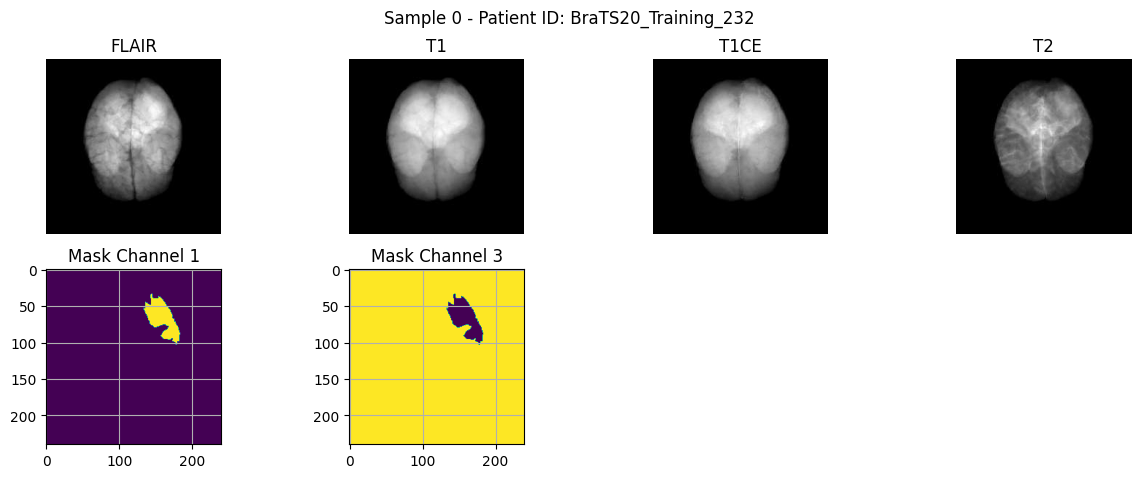

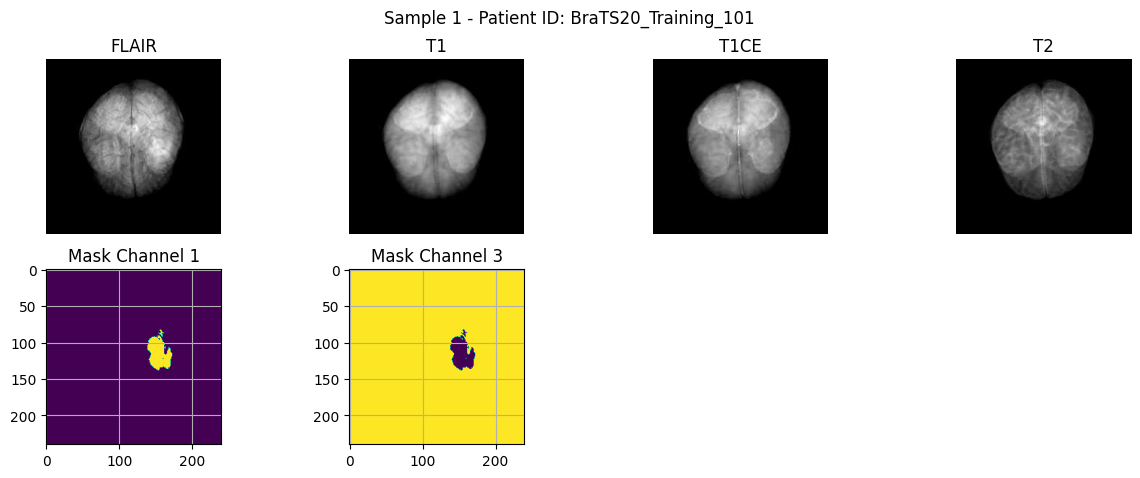

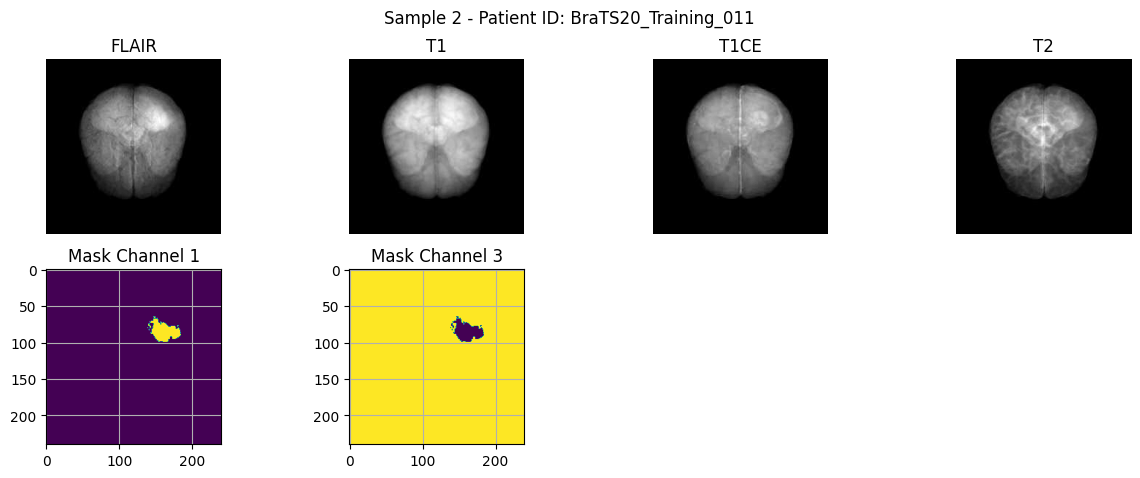

In [8]:
def visualize_samples(dataset, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with two rows
        plt.figure(figsize=(15, 5))

        # Visualize the MRI modalities in the first row
        for j in range(len(modality_types)):
            plt.subplot(2, len(modality_types), j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Visualize channels 1 and 3 of the segmentation mask side by side in the second row
        plt.subplot(2, len(modality_types), len(modality_types) + 1)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("Mask Channel 1")

        plt.subplot(2, len(modality_types), len(modality_types) + 2)
        plt.imshow(mask[3], cmap='viridis')
        plt.grid()
        plt.title("Mask Channel 3")

        plt.suptitle(f"Sample {i} - Patient ID: {patient_id}")
        plt.show()


visualize_samples(train_ds, modality_types, num_samples=3)

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024,2048)

        self.up0 = Up(2048,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up0(x6,x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [10]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [11]:
## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

## Klasa koja implementira gubitak temeljen na Dice koeficijentu
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

## Klasa koja kombinira gubitak binarne unakrsne entropije (BCE) i gubitak temeljen na Dice koeficijentu
class BCEDiceLoss(nn.Module):
    def __init__(self, alpha, beta):
        super(BCEDiceLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.beta = beta
        self.dice = DiceLoss()

    def forward(self, input, target):
        return self.alpha * self.bce(input, target) + self.beta * self.dice(input, target)

In [12]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9,0.999))
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} \nValidation Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} \nValidation Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} \nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    ## Spremanje težine modela i rezultate treniranja
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [13]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4).to(device)

In [14]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  val_dl = valid_dl,
                  criterion = BCEDiceLoss(0.5,0.5),
                  #lr = 5e-4,
                  lr = 1e-5,
                  #lr = 0.00001,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 50,
                 )

device: cuda


train epoch 1/50: 100%|██████████| 40/40 [08:43<00:00, 13.08s/it]


Loss: 0.6813 | Dice: 0.4716 | IoU: 0.3144


val epoch 1/50: 100%|██████████| 7/7 [01:27<00:00, 12.57s/it]


Loss: 0.6825 | Dice: 0.4291 | IoU: 0.2733


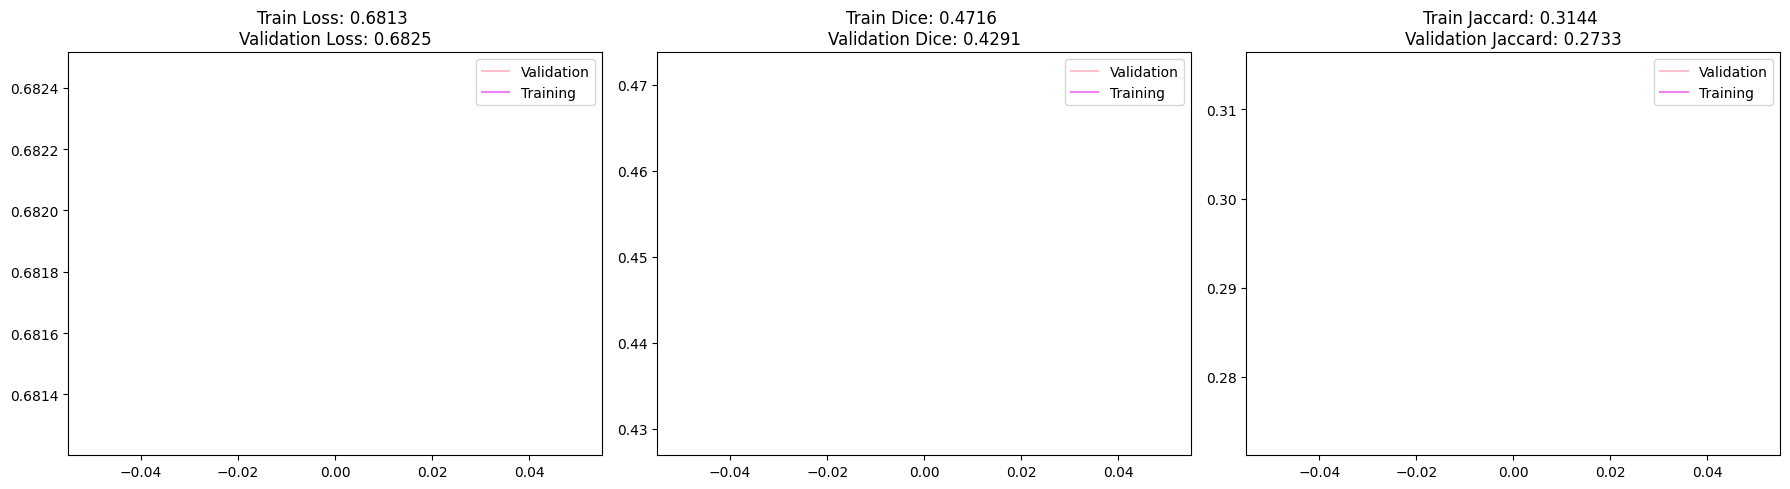

train epoch 2/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.6389 | Dice: 0.6573 | IoU: 0.4916


val epoch 2/50: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Loss: 0.6145 | Dice: 0.7411 | IoU: 0.5898


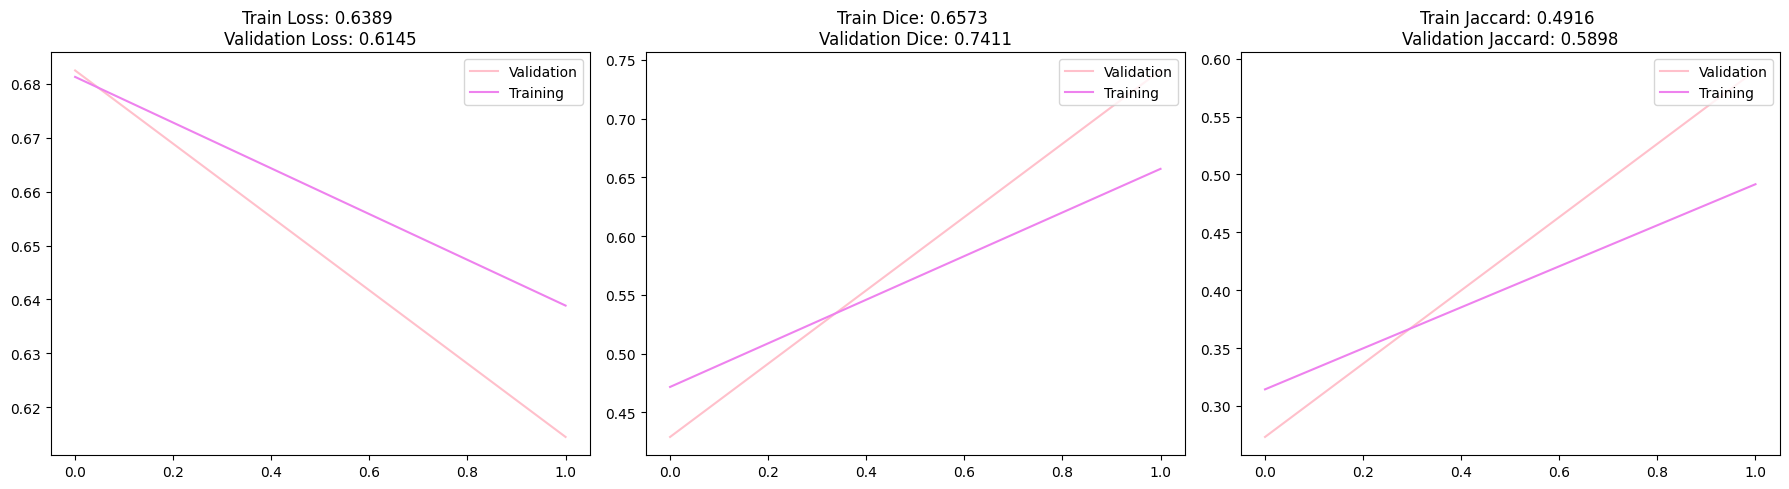

train epoch 3/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.6047 | Dice: 0.7811 | IoU: 0.6443


val epoch 3/50: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Loss: 0.5890 | Dice: 0.8468 | IoU: 0.7356


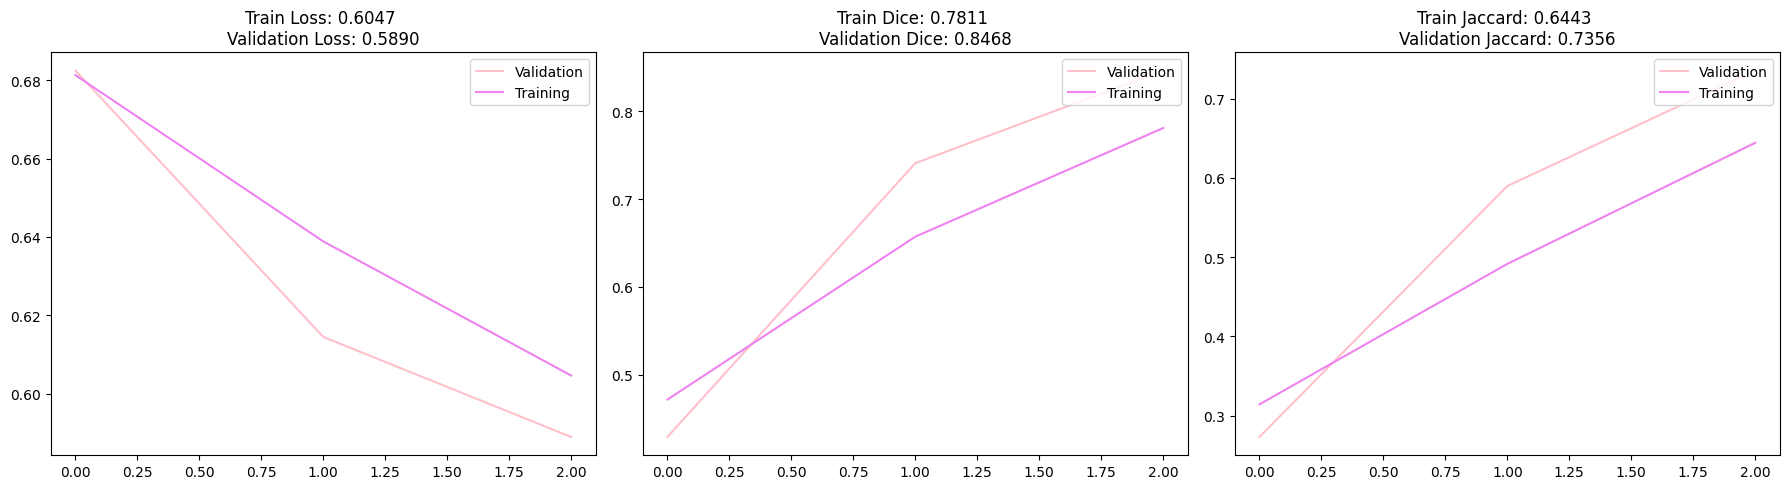

train epoch 4/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.5801 | Dice: 0.8883 | IoU: 0.8011


val epoch 4/50: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Loss: 0.5704 | Dice: 0.9239 | IoU: 0.8589


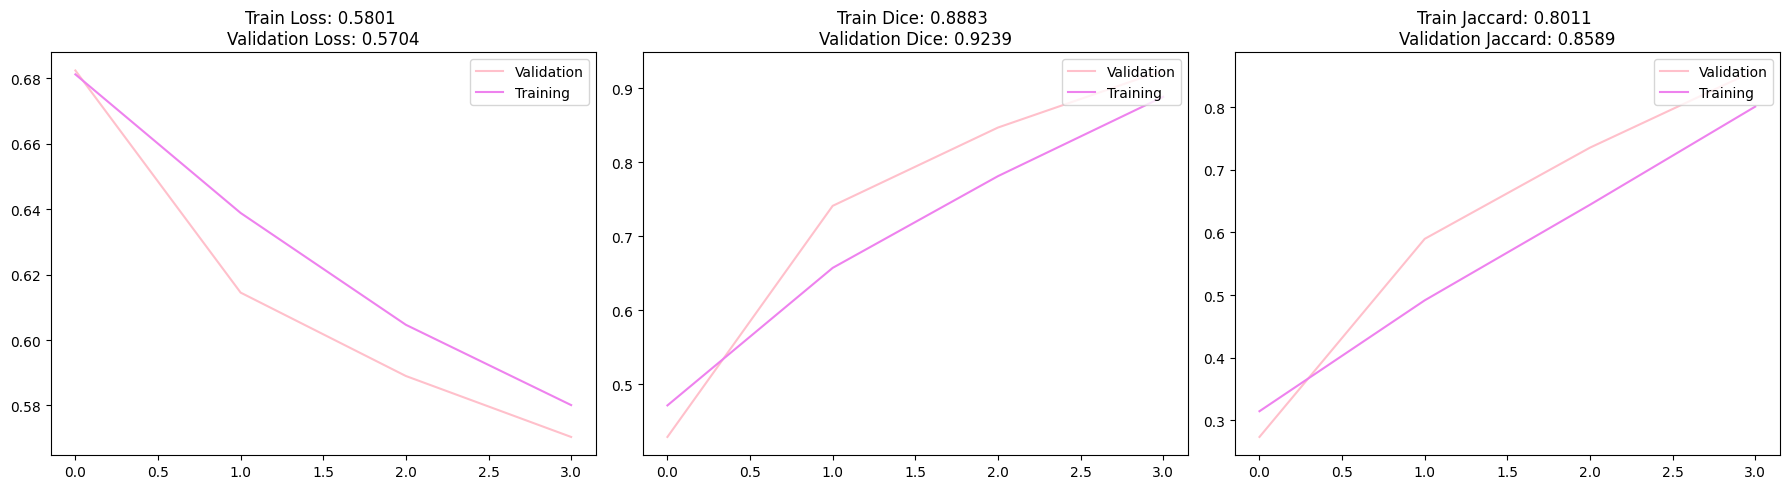

train epoch 5/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.5656 | Dice: 0.9354 | IoU: 0.8791


val epoch 5/50: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Loss: 0.5591 | Dice: 0.9480 | IoU: 0.9014


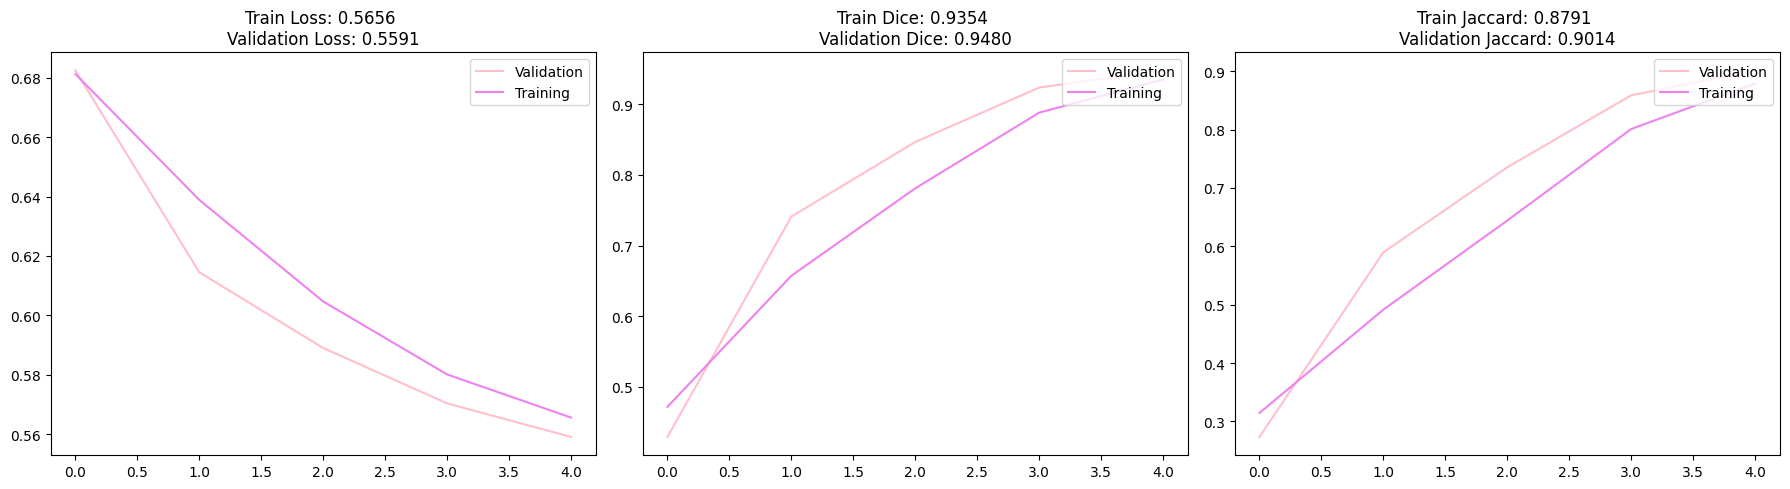

train epoch 6/50: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Loss: 0.5563 | Dice: 0.9539 | IoU: 0.9121


val epoch 6/50: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Loss: 0.5516 | Dice: 0.9601 | IoU: 0.9234


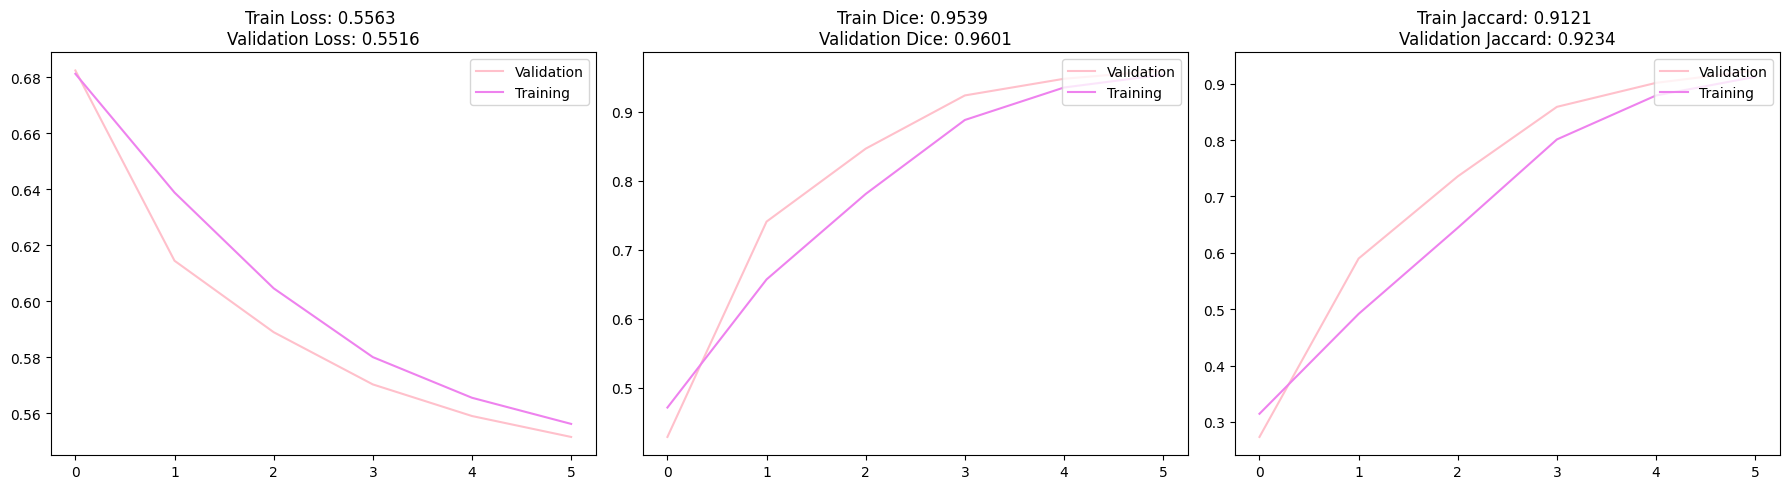

train epoch 7/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.5497 | Dice: 0.9615 | IoU: 0.9261


val epoch 7/50: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Loss: 0.5462 | Dice: 0.9651 | IoU: 0.9327


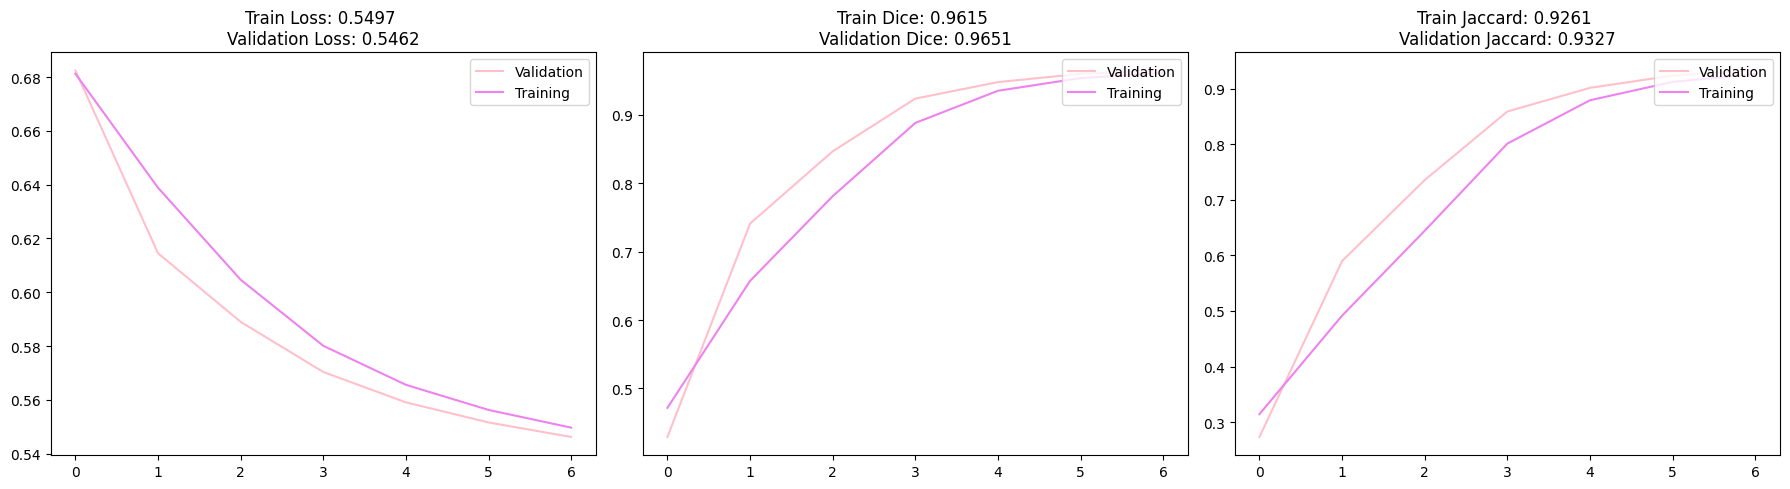

train epoch 8/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.5442 | Dice: 0.9668 | IoU: 0.9359


val epoch 8/50: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Loss: 0.5413 | Dice: 0.9694 | IoU: 0.9409


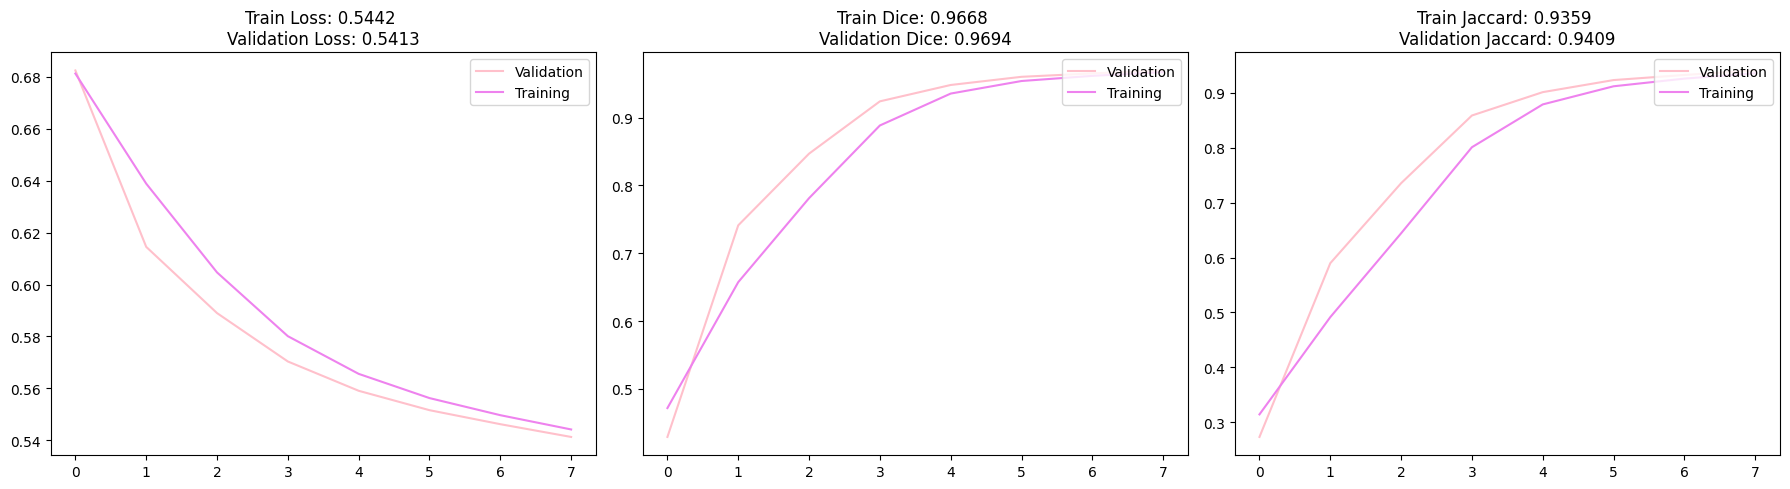

train epoch 9/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.5396 | Dice: 0.9719 | IoU: 0.9455


val epoch 9/50: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Loss: 0.5381 | Dice: 0.9710 | IoU: 0.9440


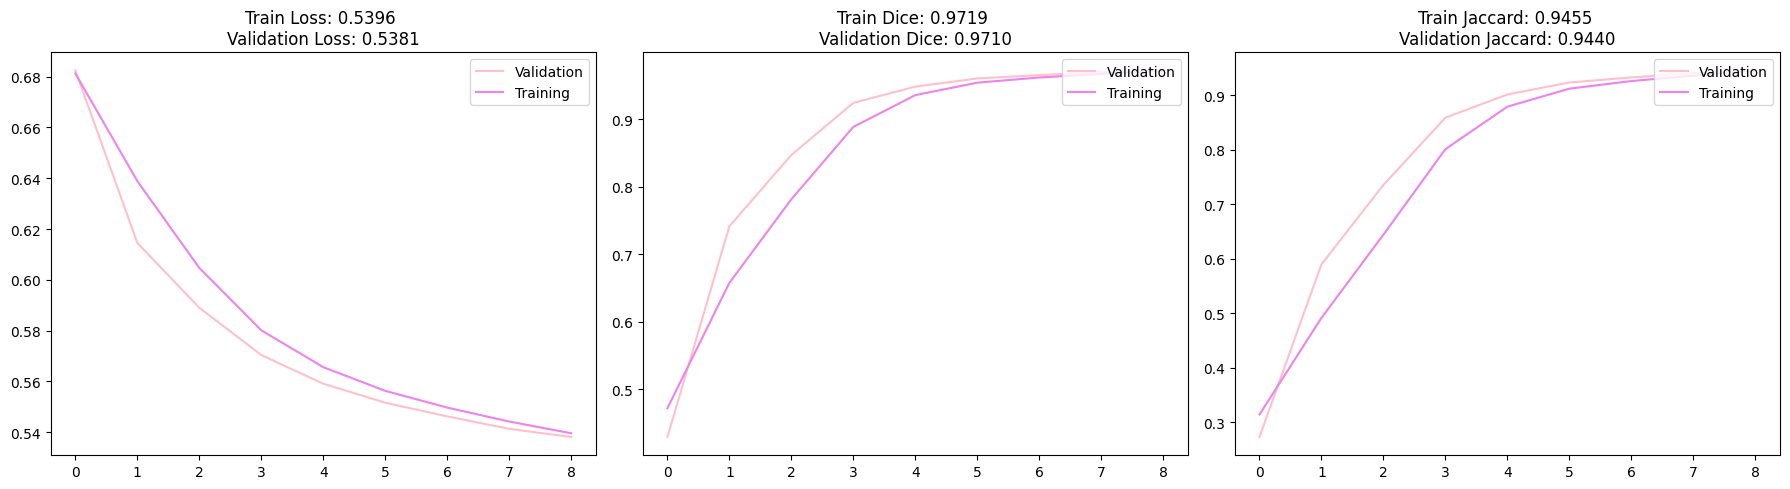

train epoch 10/50: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.5354 | Dice: 0.9748 | IoU: 0.9511


val epoch 10/50: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Loss: 0.5340 | Dice: 0.9734 | IoU: 0.9484


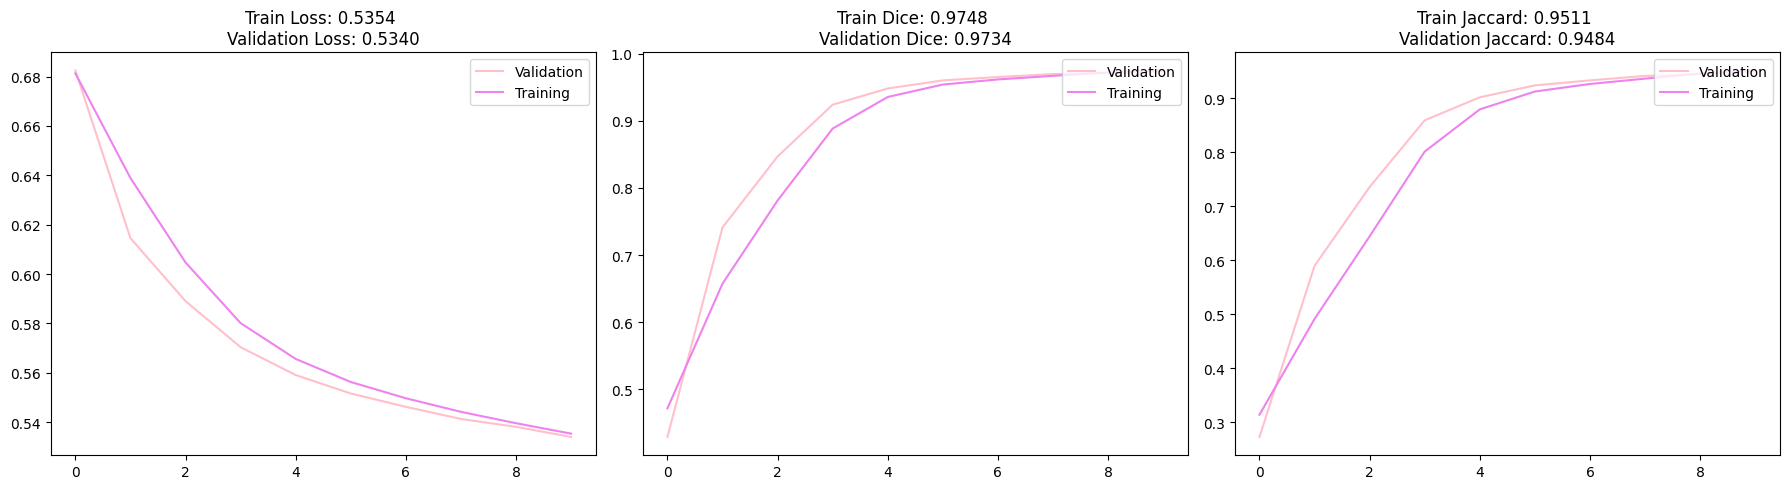

train epoch 11/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.5316 | Dice: 0.9762 | IoU: 0.9536


val epoch 11/50: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Loss: 0.5308 | Dice: 0.9757 | IoU: 0.9528


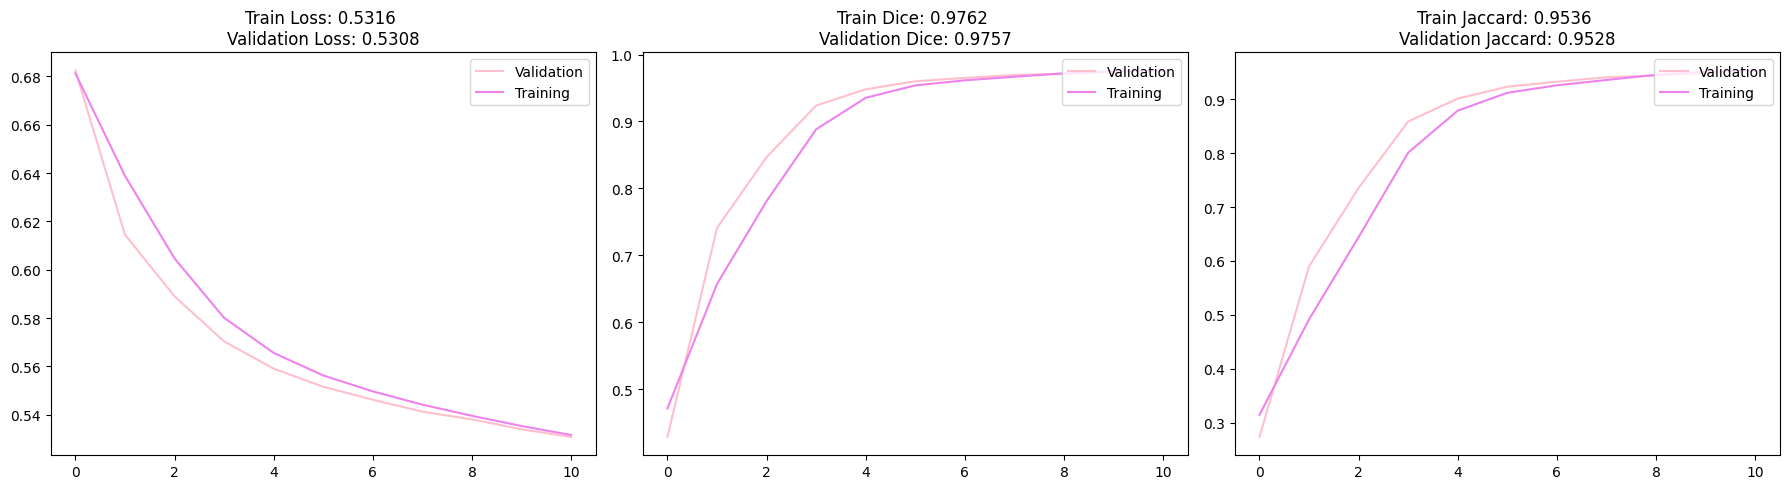

train epoch 12/50: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.5297 | Dice: 0.9735 | IoU: 0.9497


val epoch 12/50: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Loss: 0.5322 | Dice: 0.9630 | IoU: 0.9290


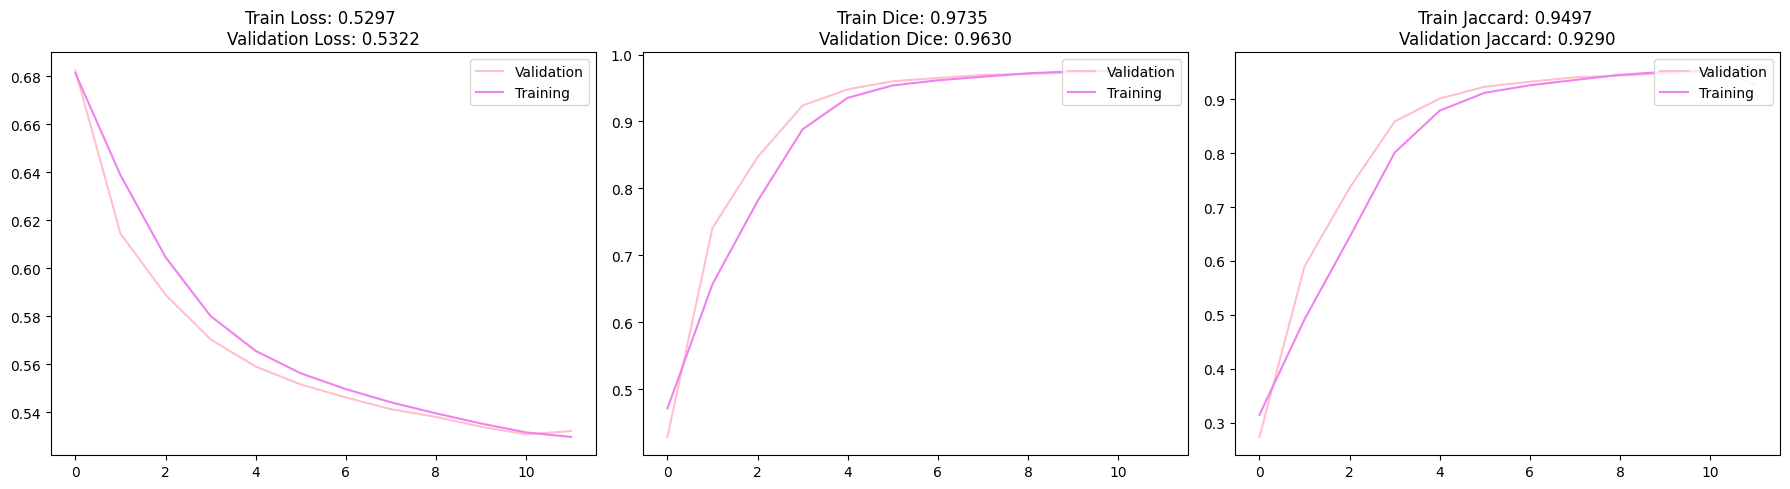

train epoch 13/50: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.5267 | Dice: 0.9748 | IoU: 0.9512


val epoch 13/50: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Loss: 0.5259 | Dice: 0.9761 | IoU: 0.9537


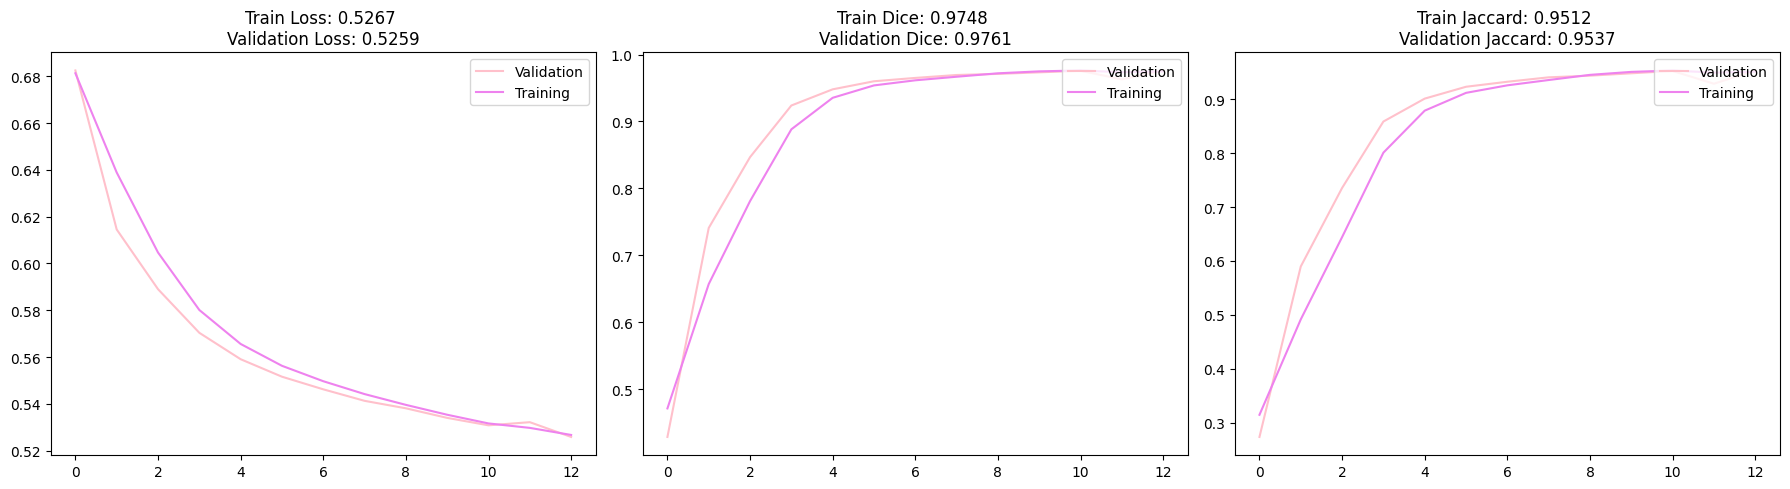

train epoch 14/50: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.5215 | Dice: 0.9791 | IoU: 0.9592


val epoch 14/50: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Loss: 0.5200 | Dice: 0.9793 | IoU: 0.9596


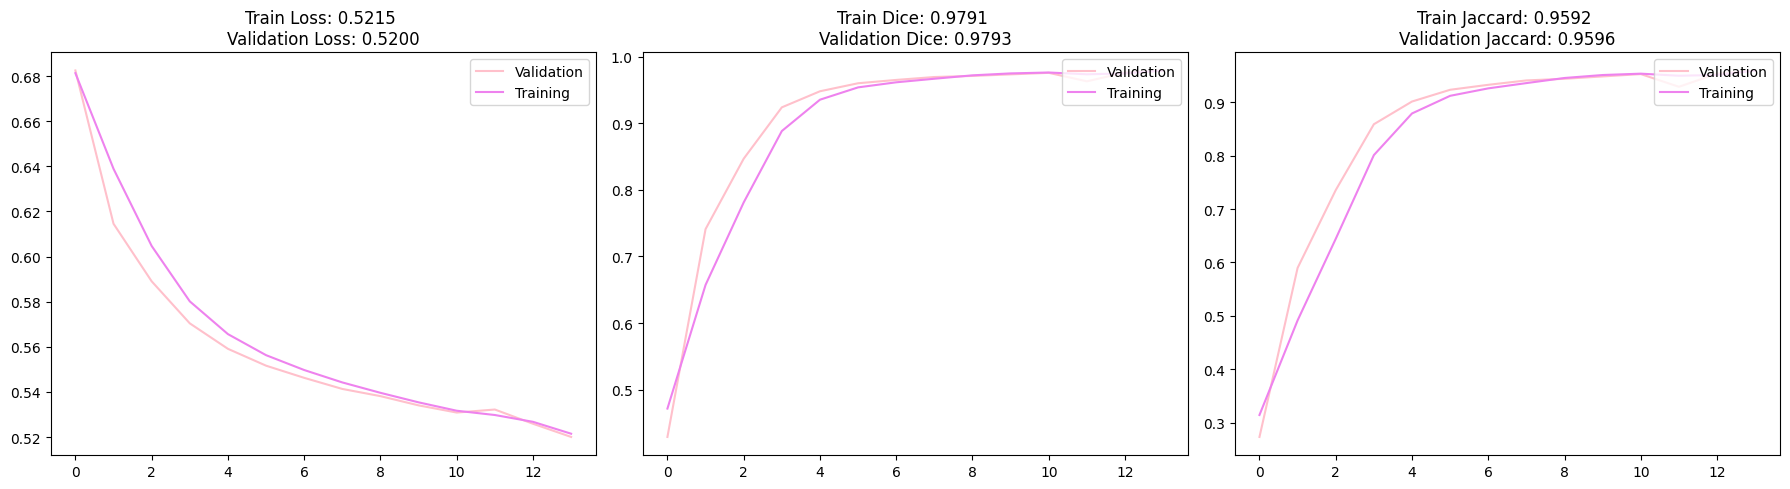

train epoch 15/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.5181 | Dice: 0.9786 | IoU: 0.9583


val epoch 15/50: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Loss: 0.5177 | Dice: 0.9761 | IoU: 0.9536


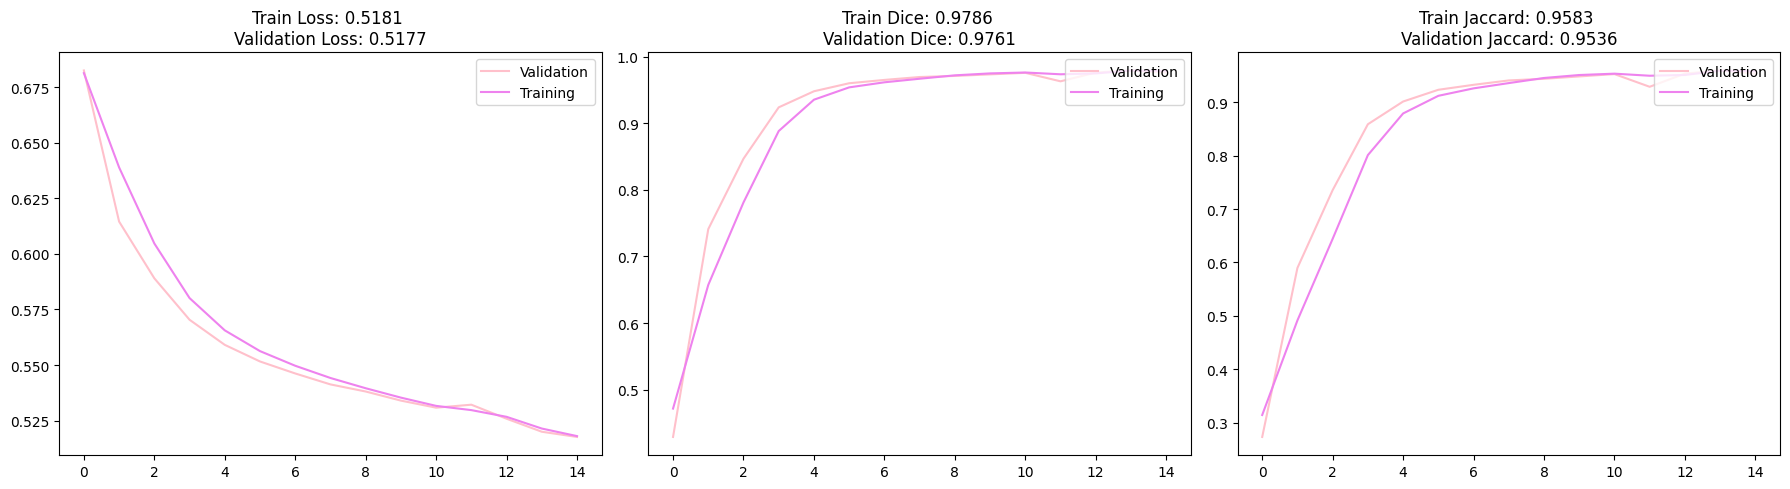

train epoch 16/50: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.5136 | Dice: 0.9799 | IoU: 0.9608


val epoch 16/50: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.5148 | Dice: 0.9784 | IoU: 0.9581


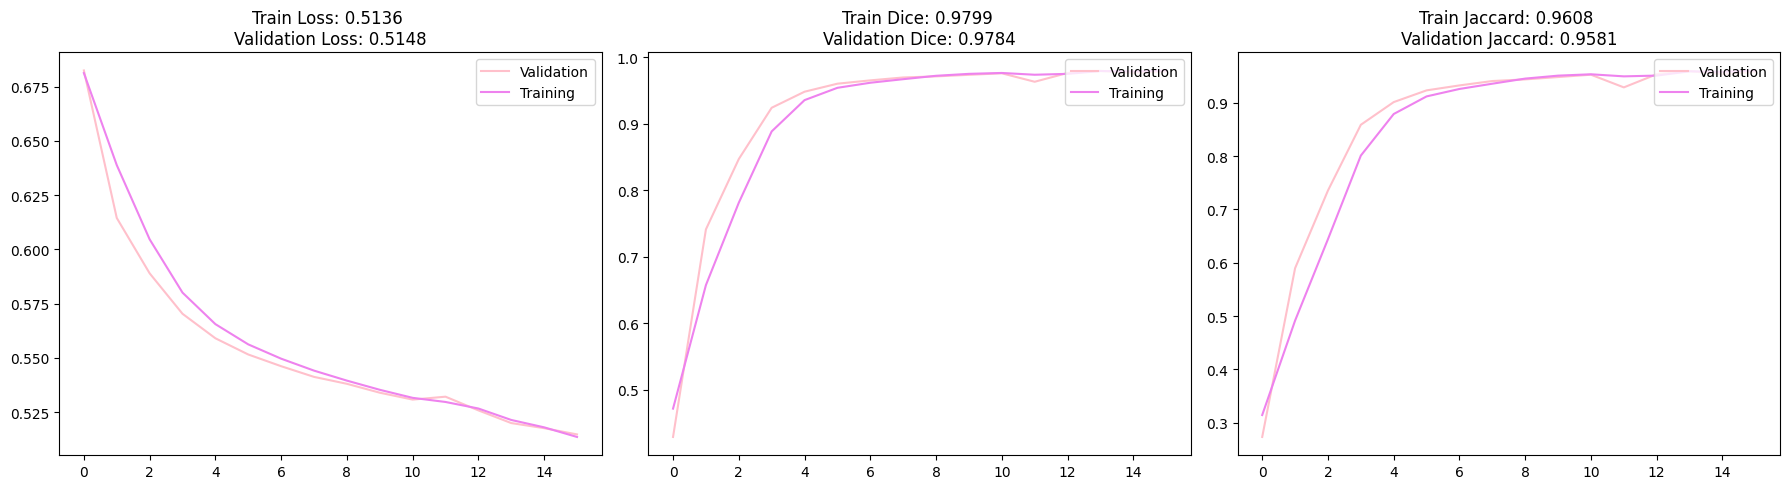

train epoch 17/50: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.5087 | Dice: 0.9804 | IoU: 0.9617


val epoch 17/50: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Loss: 0.5086 | Dice: 0.9784 | IoU: 0.9580


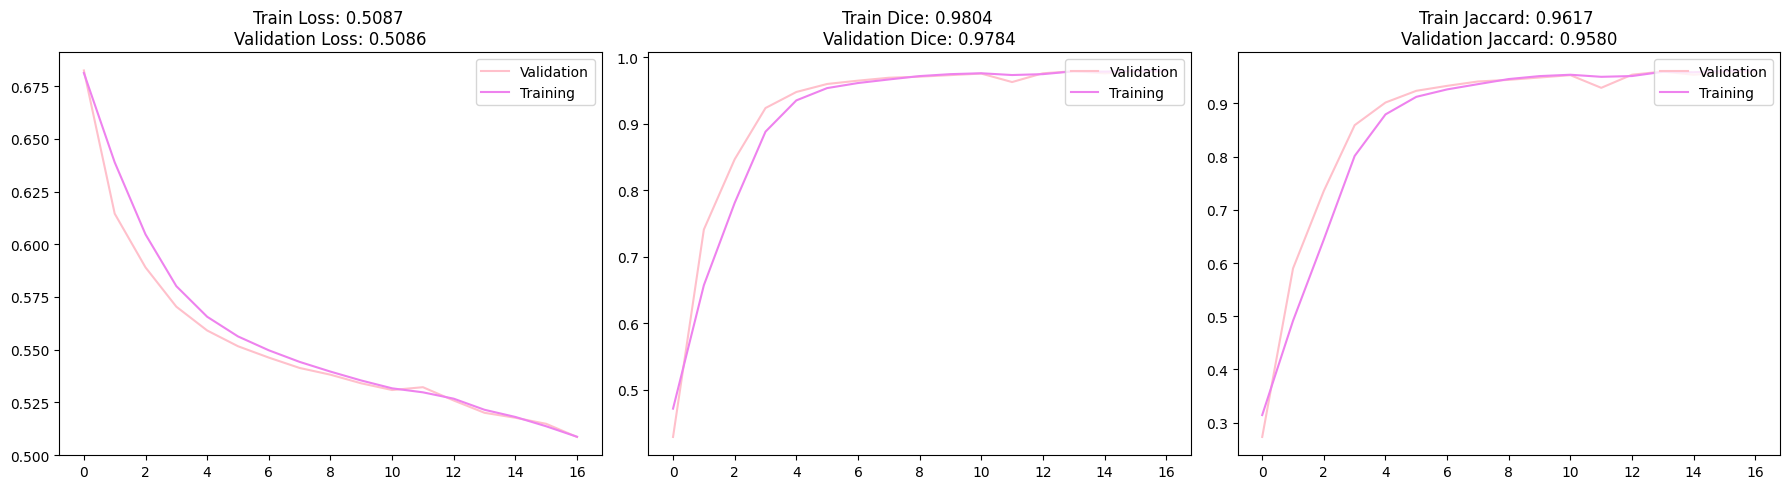

train epoch 18/50: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.5039 | Dice: 0.9806 | IoU: 0.9621


val epoch 18/50: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Loss: 0.5033 | Dice: 0.9789 | IoU: 0.9589


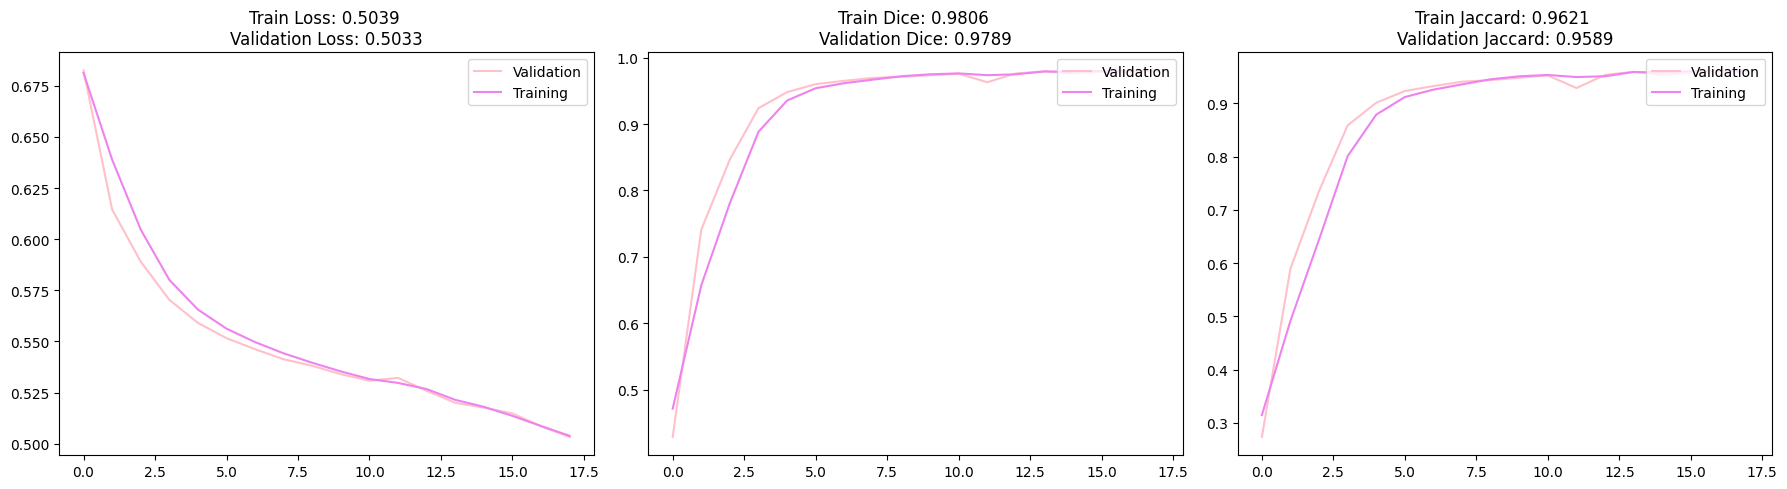

train epoch 19/50: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


Loss: 0.4987 | Dice: 0.9837 | IoU: 0.9680


val epoch 19/50: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Loss: 0.5001 | Dice: 0.9800 | IoU: 0.9609


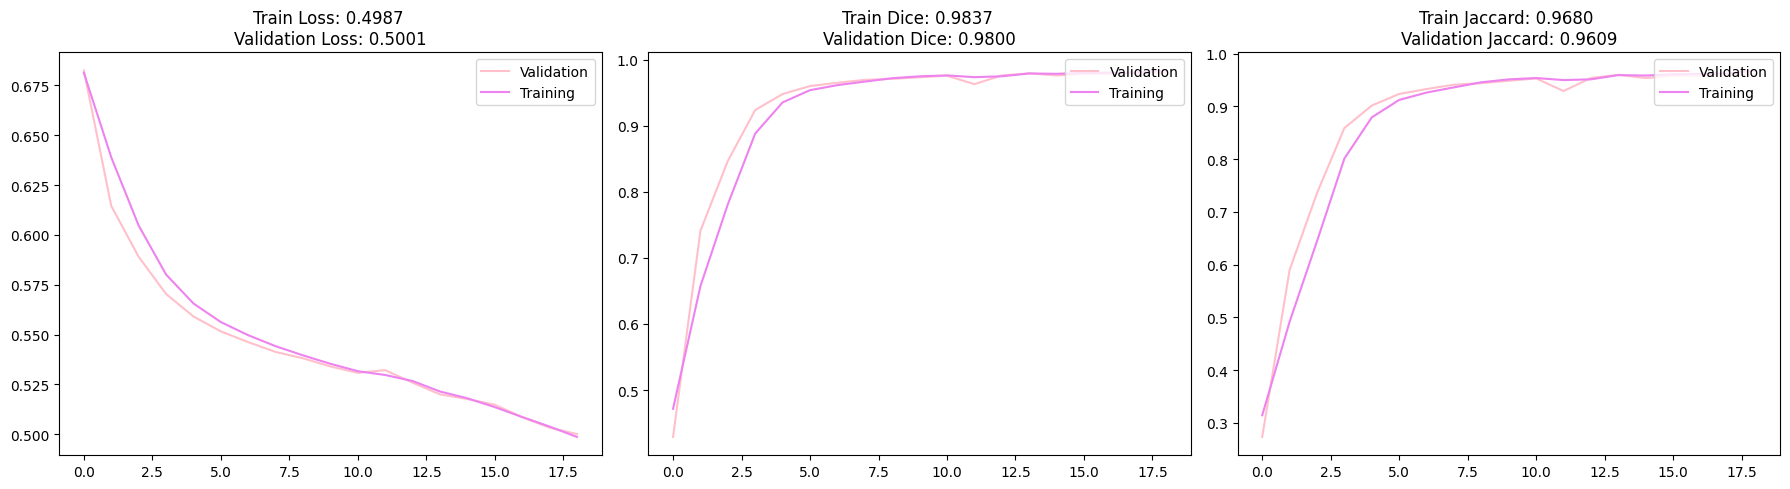

train epoch 20/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.4950 | Dice: 0.9844 | IoU: 0.9694


val epoch 20/50: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Loss: 0.4938 | Dice: 0.9831 | IoU: 0.9670


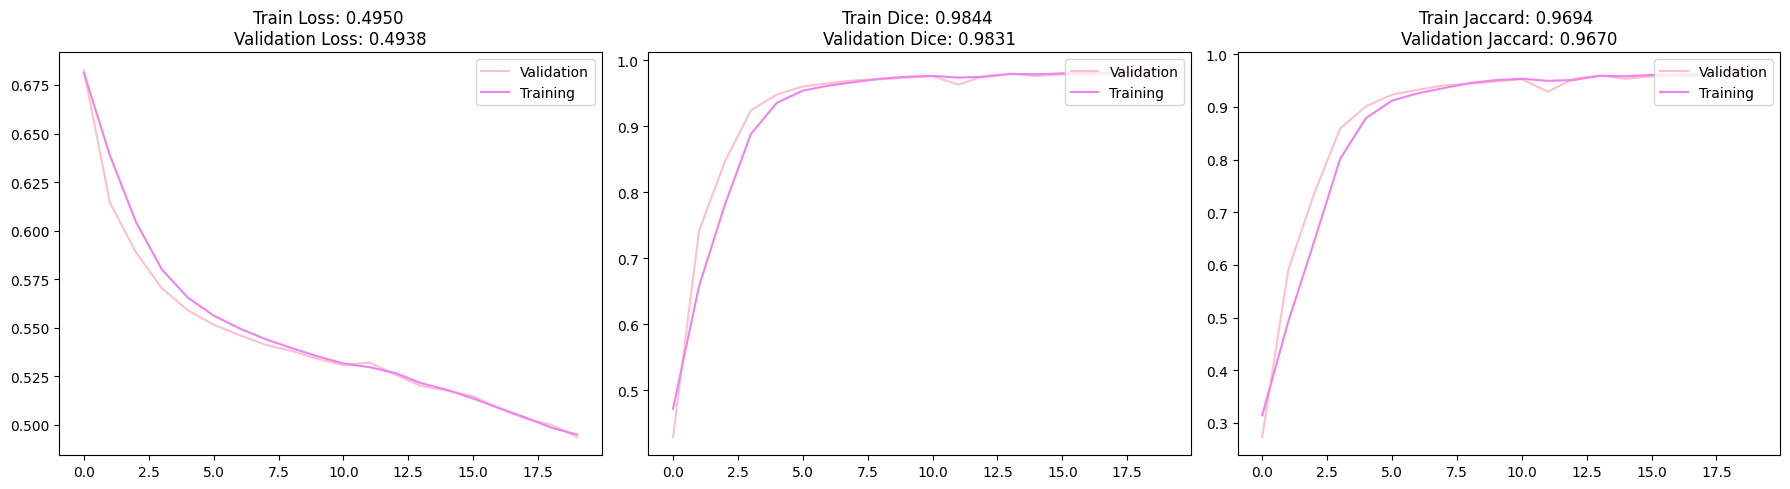

train epoch 21/50: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Loss: 0.4913 | Dice: 0.9849 | IoU: 0.9703


val epoch 21/50: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Loss: 0.4897 | Dice: 0.9846 | IoU: 0.9699


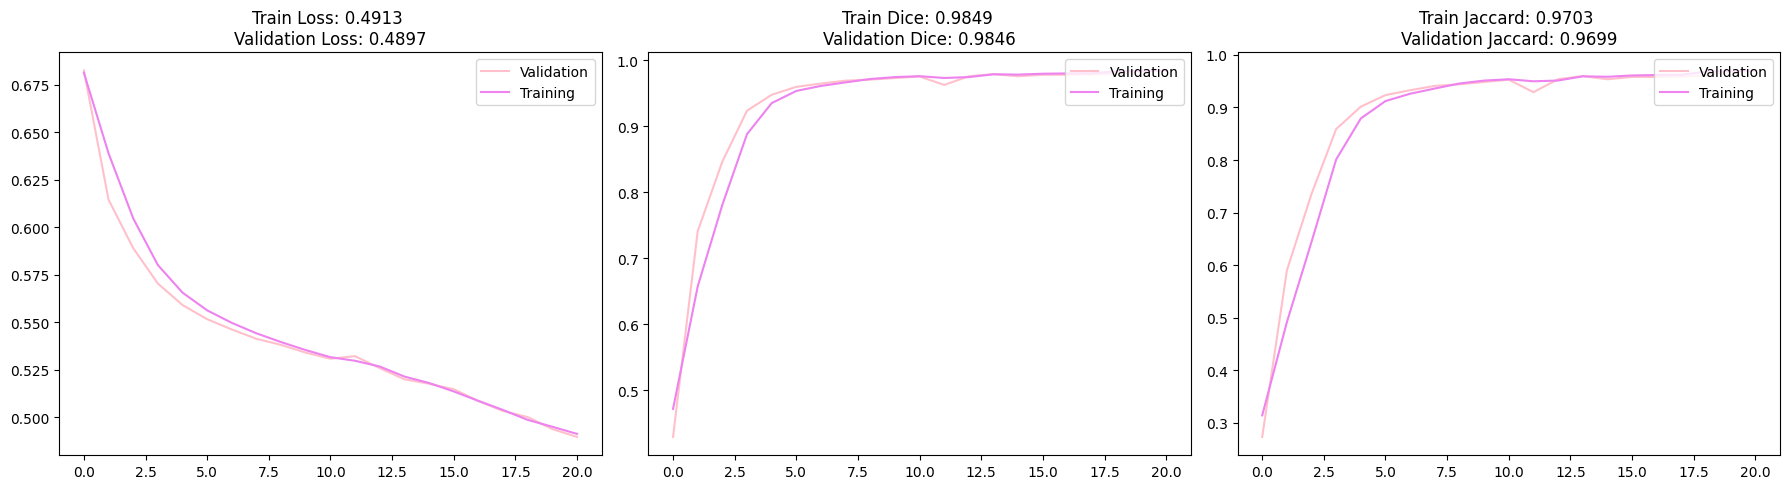

train epoch 22/50: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.4877 | Dice: 0.9860 | IoU: 0.9725


val epoch 22/50: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Loss: 0.4898 | Dice: 0.9824 | IoU: 0.9657


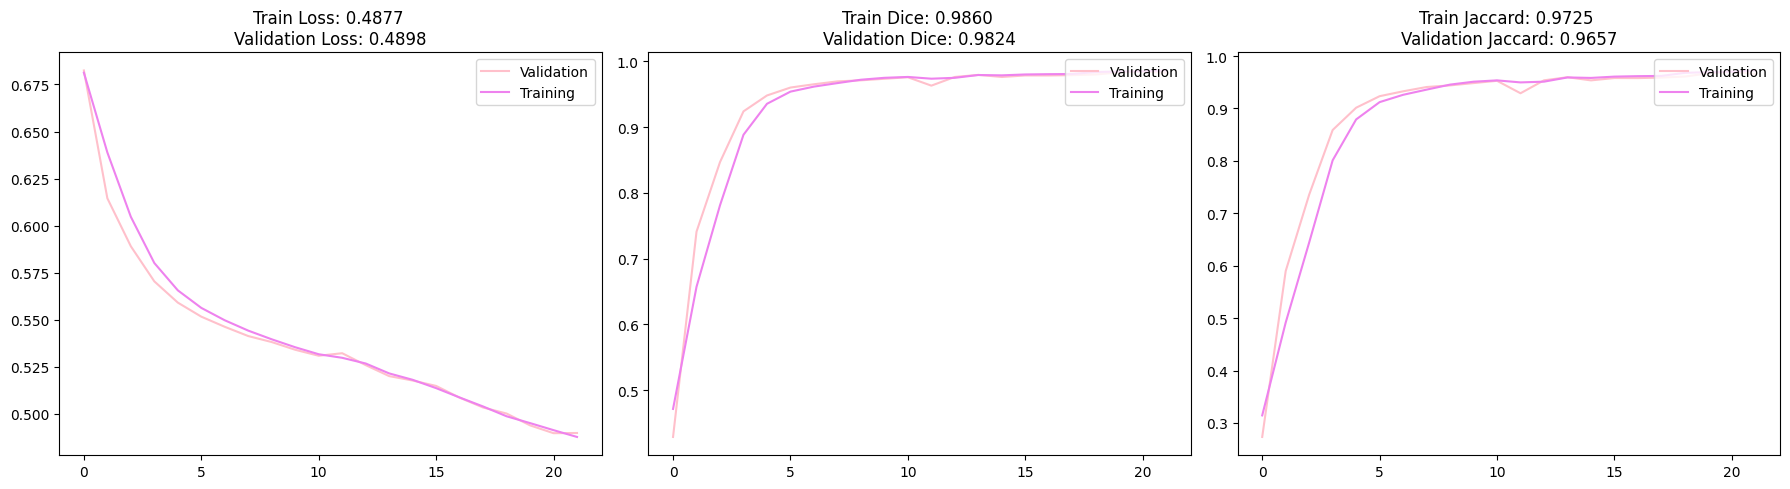

train epoch 23/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.4845 | Dice: 0.9865 | IoU: 0.9734


val epoch 23/50: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Loss: 0.4839 | Dice: 0.9857 | IoU: 0.9720


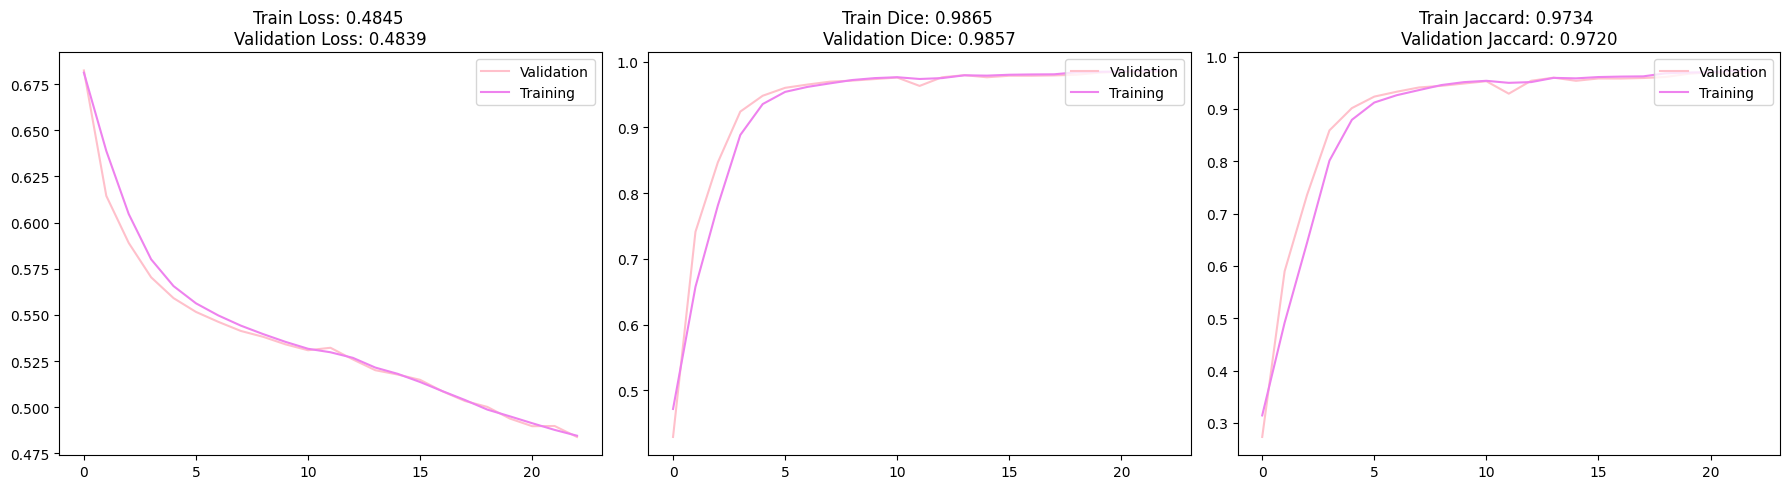

train epoch 24/50: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Loss: 0.4816 | Dice: 0.9872 | IoU: 0.9748


val epoch 24/50: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Loss: 0.4817 | Dice: 0.9844 | IoU: 0.9694


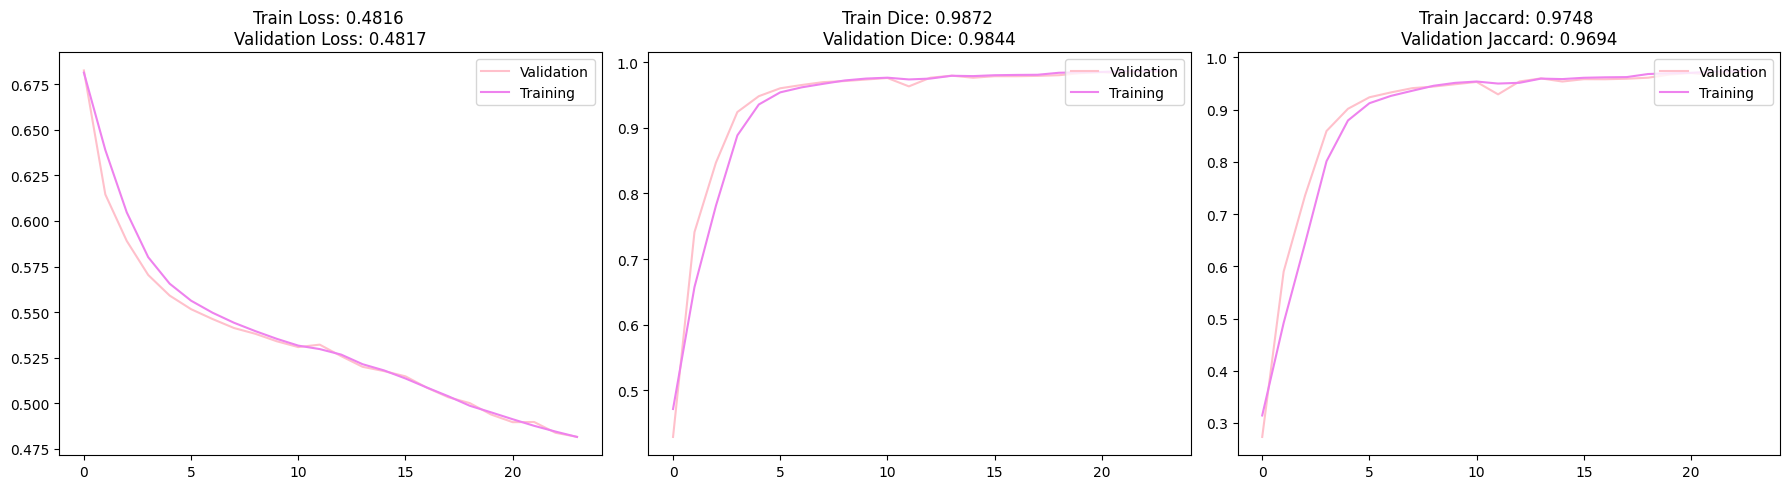

train epoch 25/50: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.4783 | Dice: 0.9881 | IoU: 0.9765


val epoch 25/50: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Loss: 0.4776 | Dice: 0.9868 | IoU: 0.9741


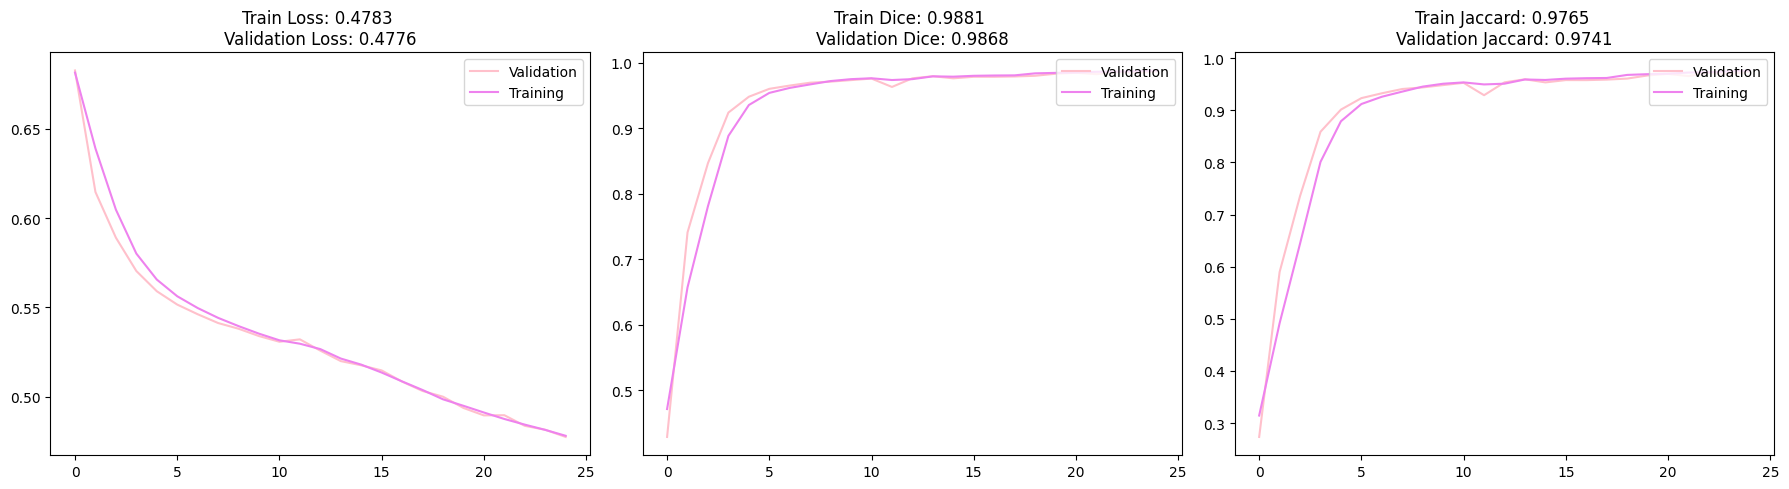

train epoch 26/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4751 | Dice: 0.9884 | IoU: 0.9771


val epoch 26/50: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Loss: 0.4755 | Dice: 0.9861 | IoU: 0.9728


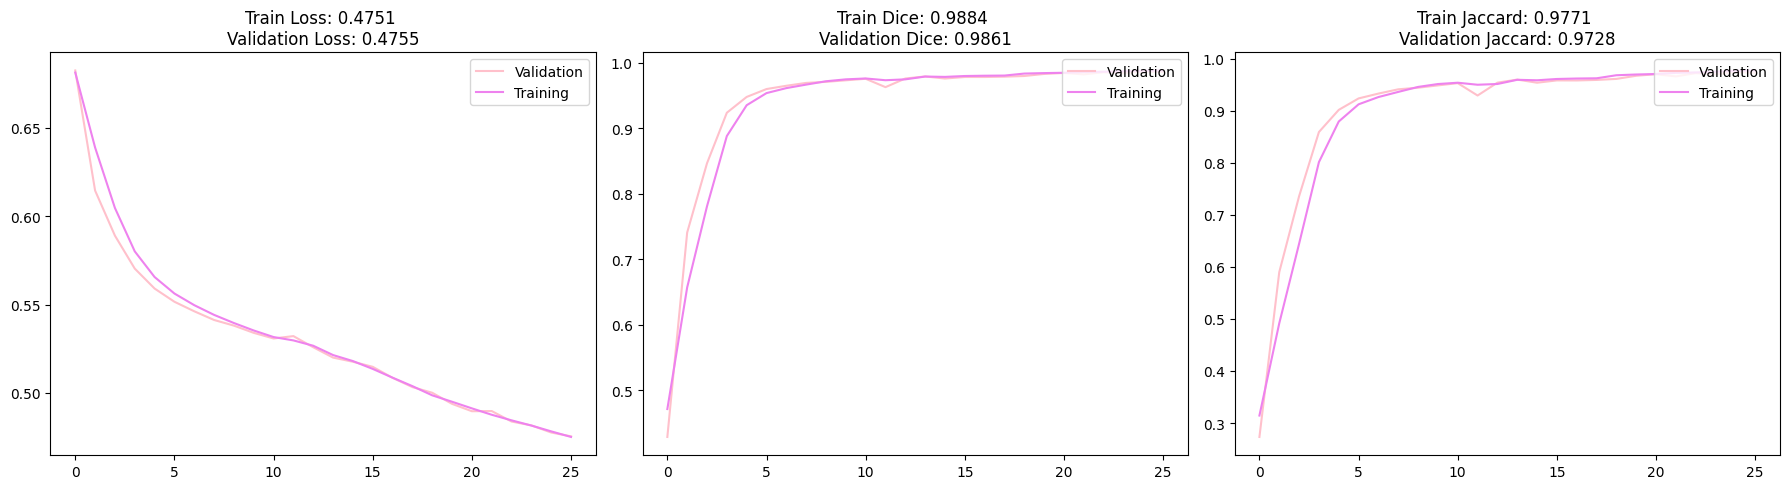

train epoch 27/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4720 | Dice: 0.9890 | IoU: 0.9783


val epoch 27/50: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Loss: 0.4748 | Dice: 0.9826 | IoU: 0.9661


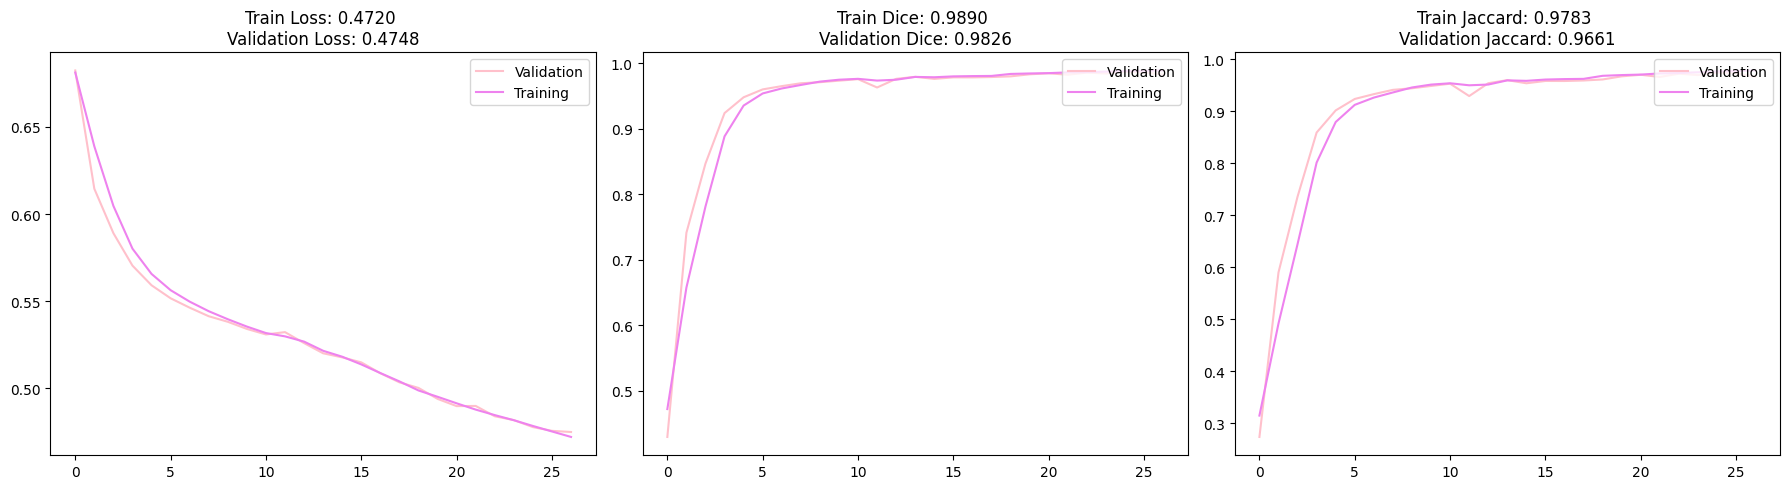

train epoch 28/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4692 | Dice: 0.9890 | IoU: 0.9783


val epoch 28/50: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Loss: 0.4708 | Dice: 0.9851 | IoU: 0.9708


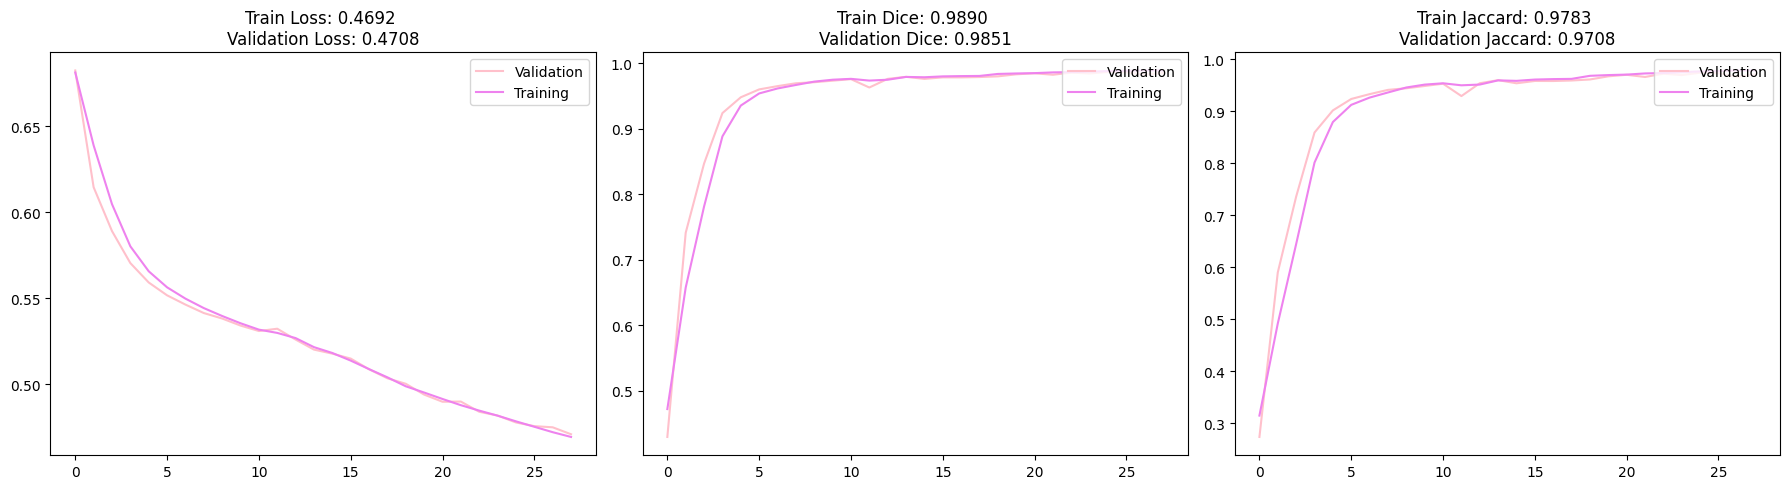

train epoch 29/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4664 | Dice: 0.9896 | IoU: 0.9794


val epoch 29/50: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Loss: 0.4670 | Dice: 0.9870 | IoU: 0.9745


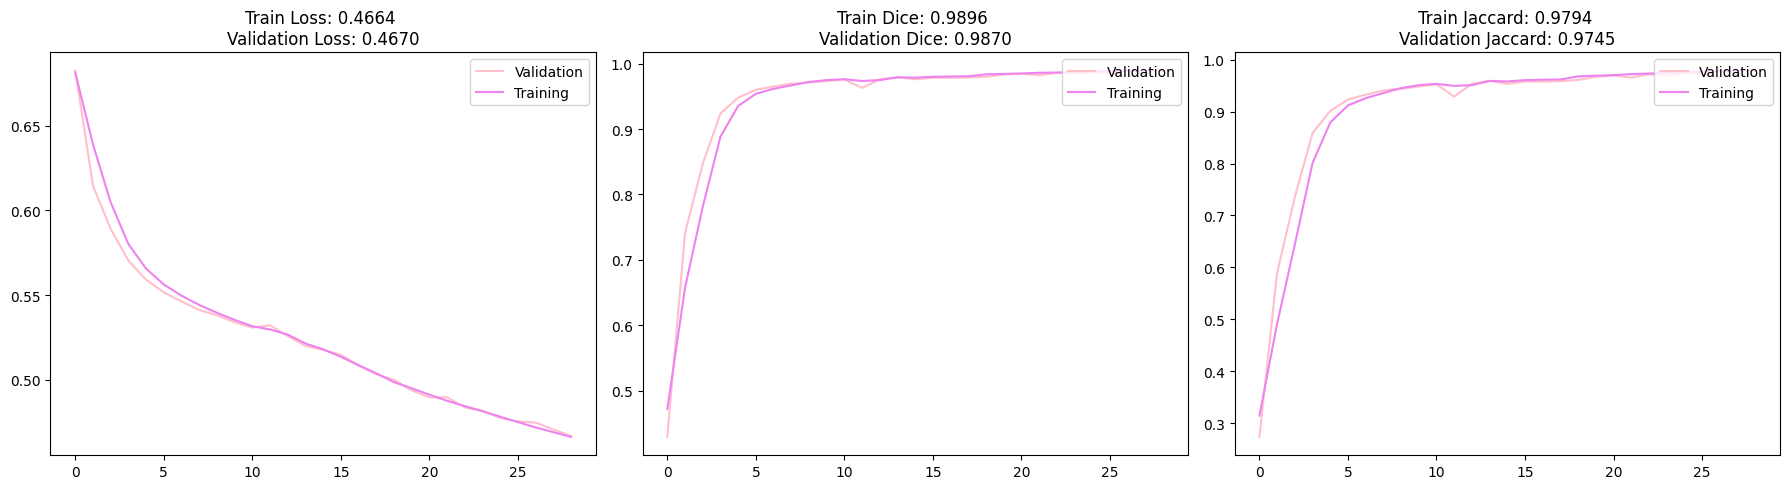

train epoch 30/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4634 | Dice: 0.9905 | IoU: 0.9812


val epoch 30/50: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Loss: 0.4639 | Dice: 0.9876 | IoU: 0.9756


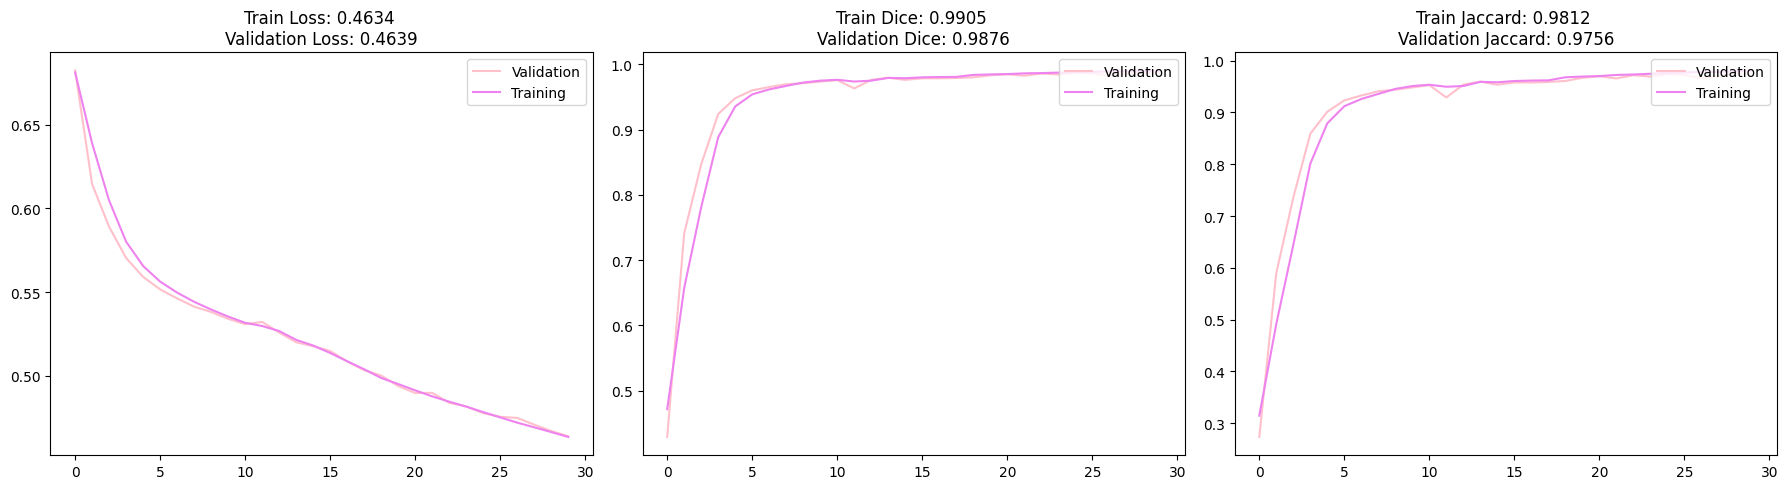

train epoch 31/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4606 | Dice: 0.9909 | IoU: 0.9821


val epoch 31/50: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Loss: 0.4629 | Dice: 0.9850 | IoU: 0.9706


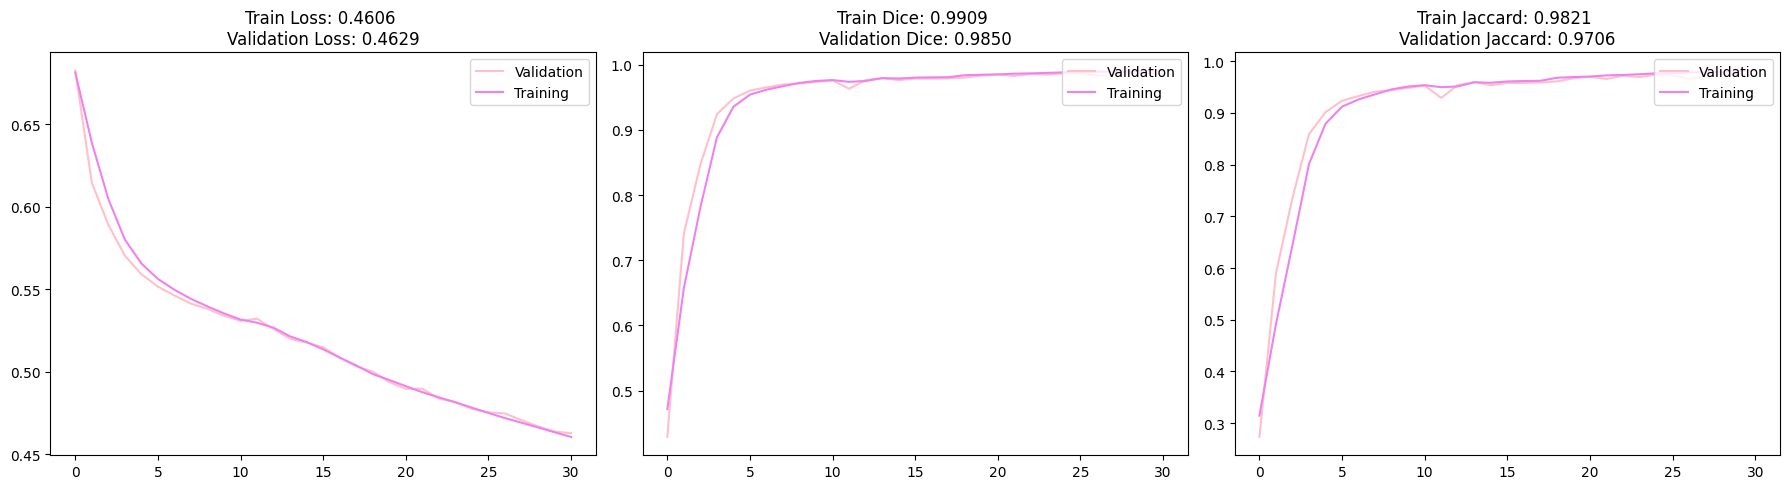

train epoch 32/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4578 | Dice: 0.9913 | IoU: 0.9828


val epoch 32/50: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Loss: 0.4583 | Dice: 0.9873 | IoU: 0.9751


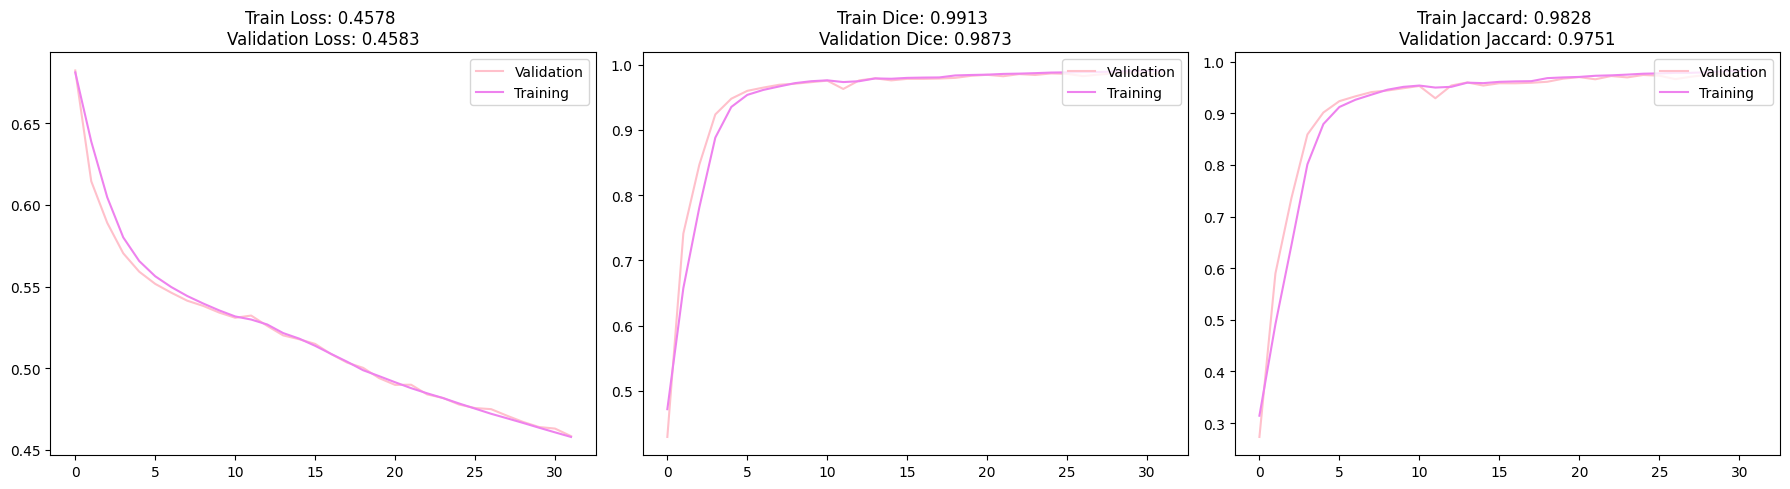

train epoch 33/50: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Loss: 0.4552 | Dice: 0.9914 | IoU: 0.9830


val epoch 33/50: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.4562 | Dice: 0.9873 | IoU: 0.9751


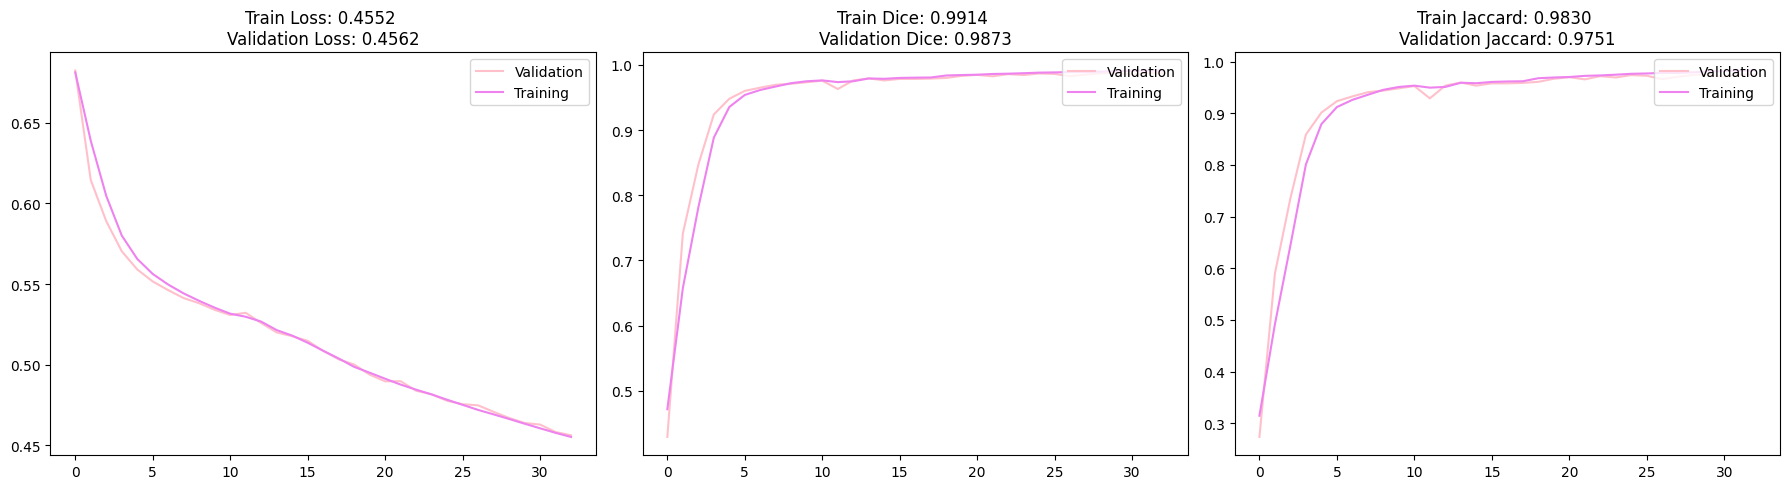

train epoch 34/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4525 | Dice: 0.9918 | IoU: 0.9838


val epoch 34/50: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Loss: 0.4535 | Dice: 0.9871 | IoU: 0.9746


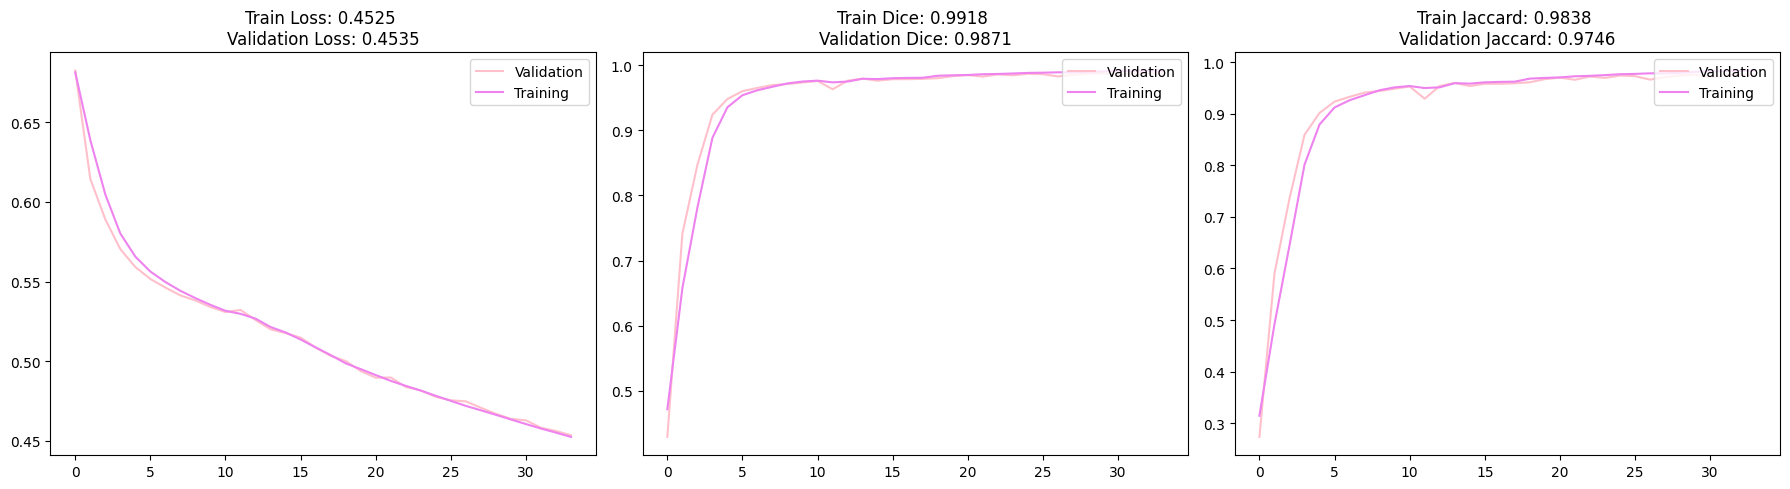

train epoch 35/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4498 | Dice: 0.9920 | IoU: 0.9842


val epoch 35/50: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Loss: 0.4515 | Dice: 0.9868 | IoU: 0.9741


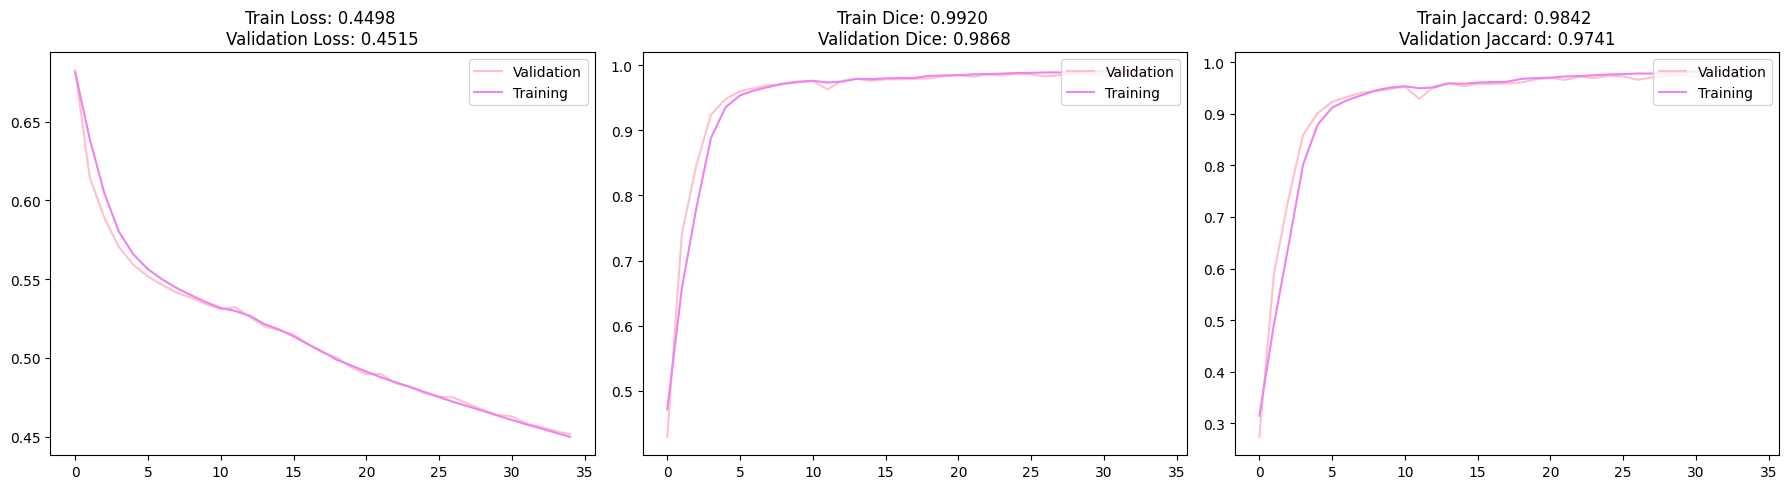

train epoch 36/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4470 | Dice: 0.9923 | IoU: 0.9848


val epoch 36/50: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Loss: 0.4489 | Dice: 0.9881 | IoU: 0.9766


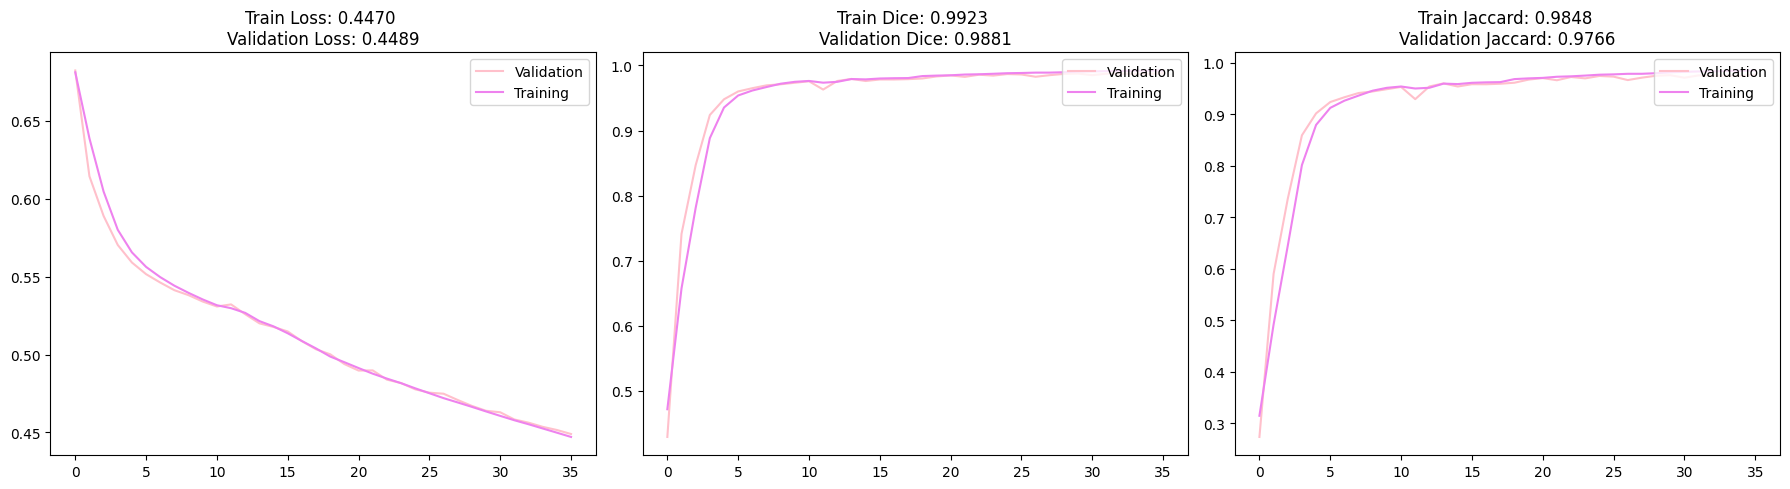

train epoch 37/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4443 | Dice: 0.9927 | IoU: 0.9855


val epoch 37/50: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Loss: 0.4452 | Dice: 0.9881 | IoU: 0.9766


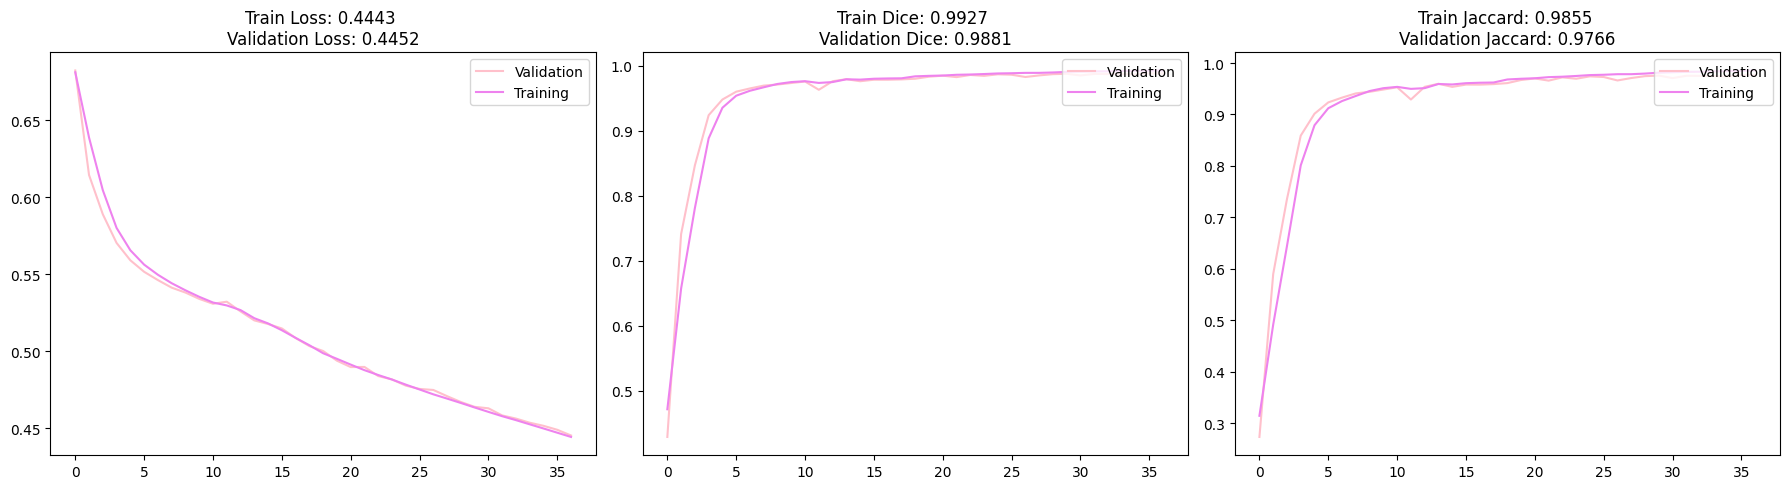

train epoch 38/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4416 | Dice: 0.9929 | IoU: 0.9859


val epoch 38/50: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Loss: 0.4452 | Dice: 0.9860 | IoU: 0.9724


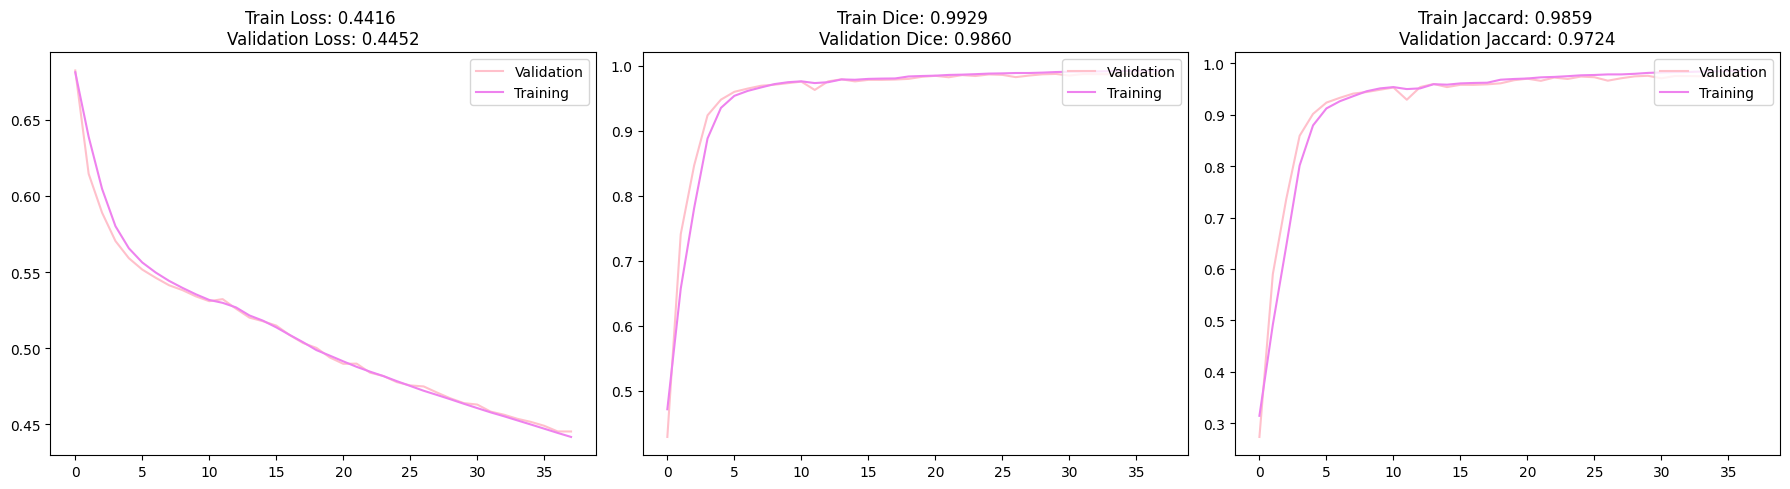

train epoch 39/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4393 | Dice: 0.9922 | IoU: 0.9845


val epoch 39/50: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.4437 | Dice: 0.9817 | IoU: 0.9643


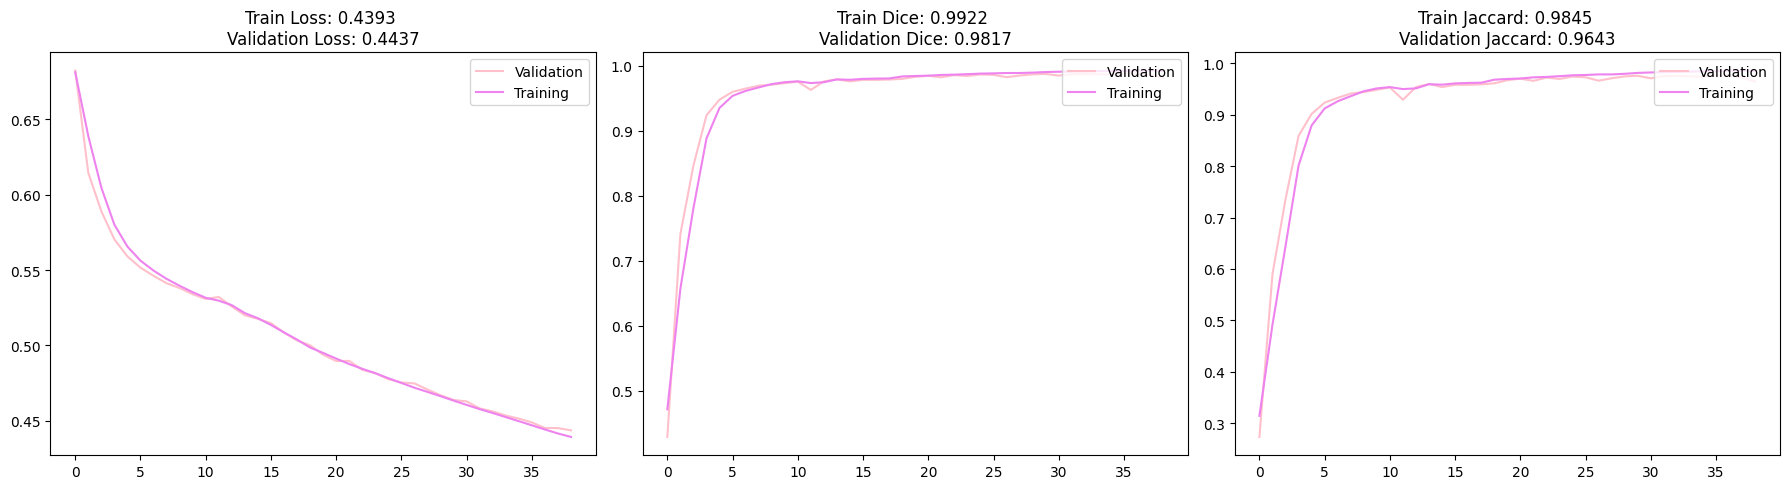

train epoch 40/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4384 | Dice: 0.9893 | IoU: 0.9790


val epoch 40/50: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.4384 | Dice: 0.9863 | IoU: 0.9730


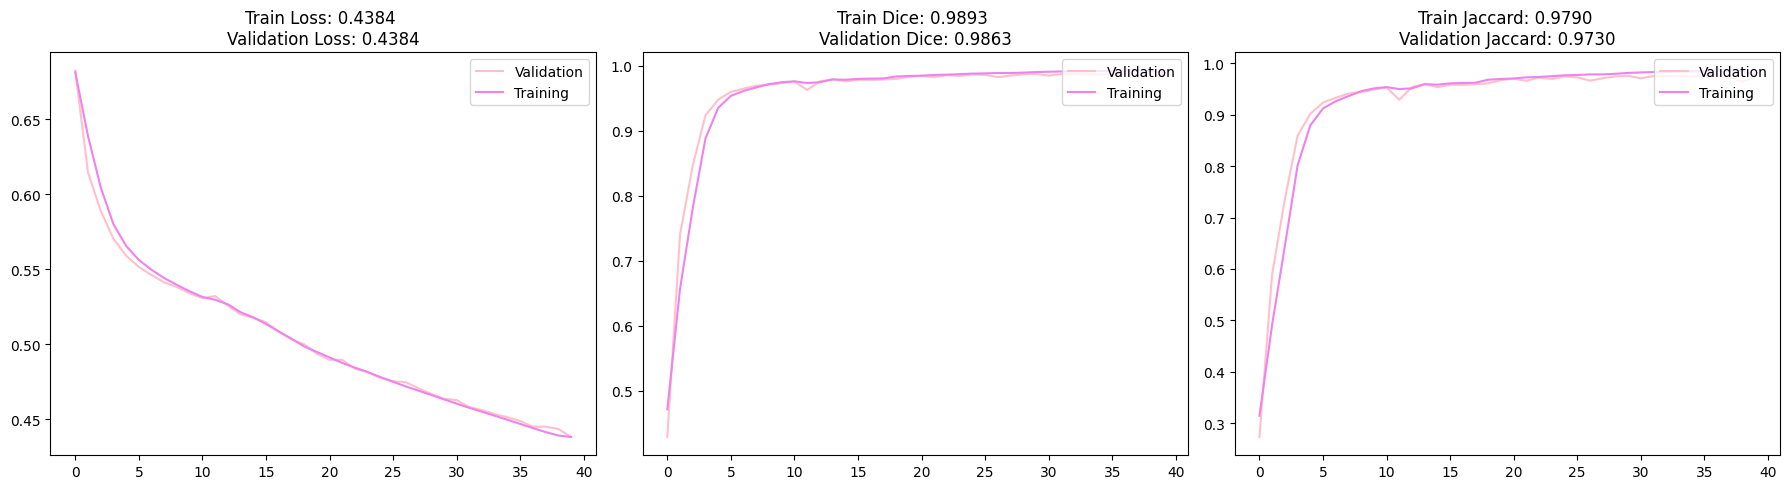

train epoch 41/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4344 | Dice: 0.9912 | IoU: 0.9827


val epoch 41/50: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Loss: 0.4342 | Dice: 0.9883 | IoU: 0.9770


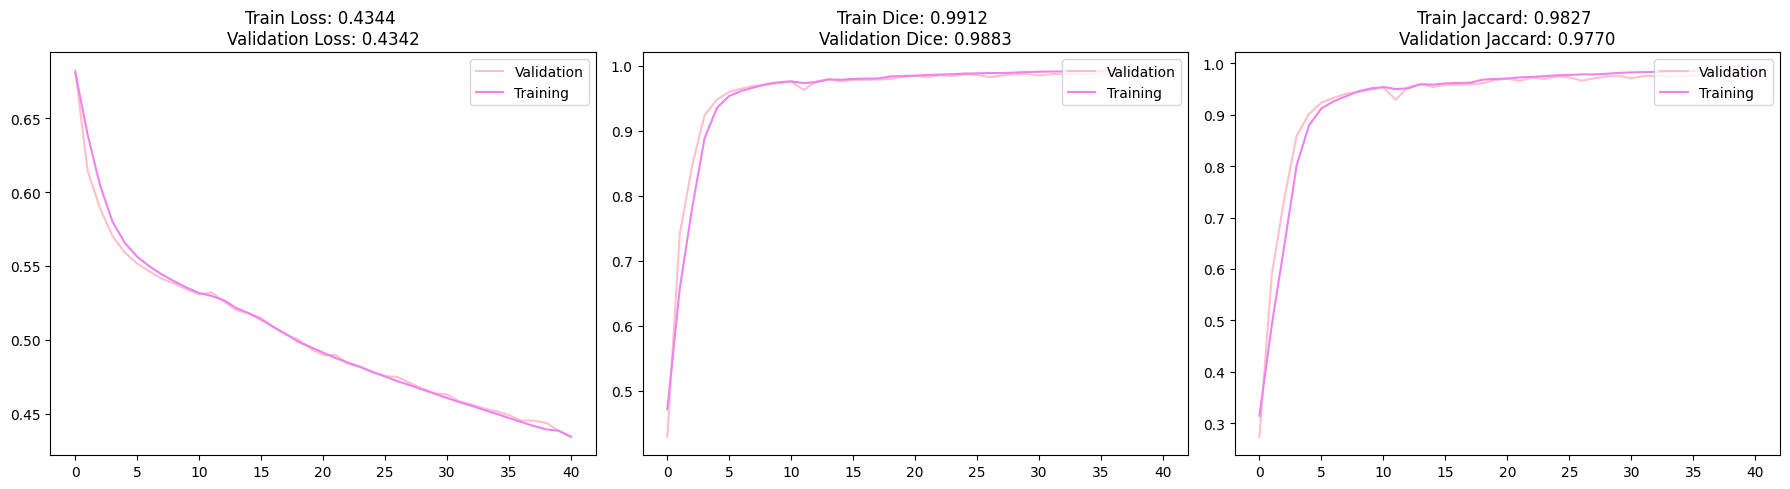

train epoch 42/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4308 | Dice: 0.9925 | IoU: 0.9851


val epoch 42/50: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Loss: 0.4316 | Dice: 0.9883 | IoU: 0.9771


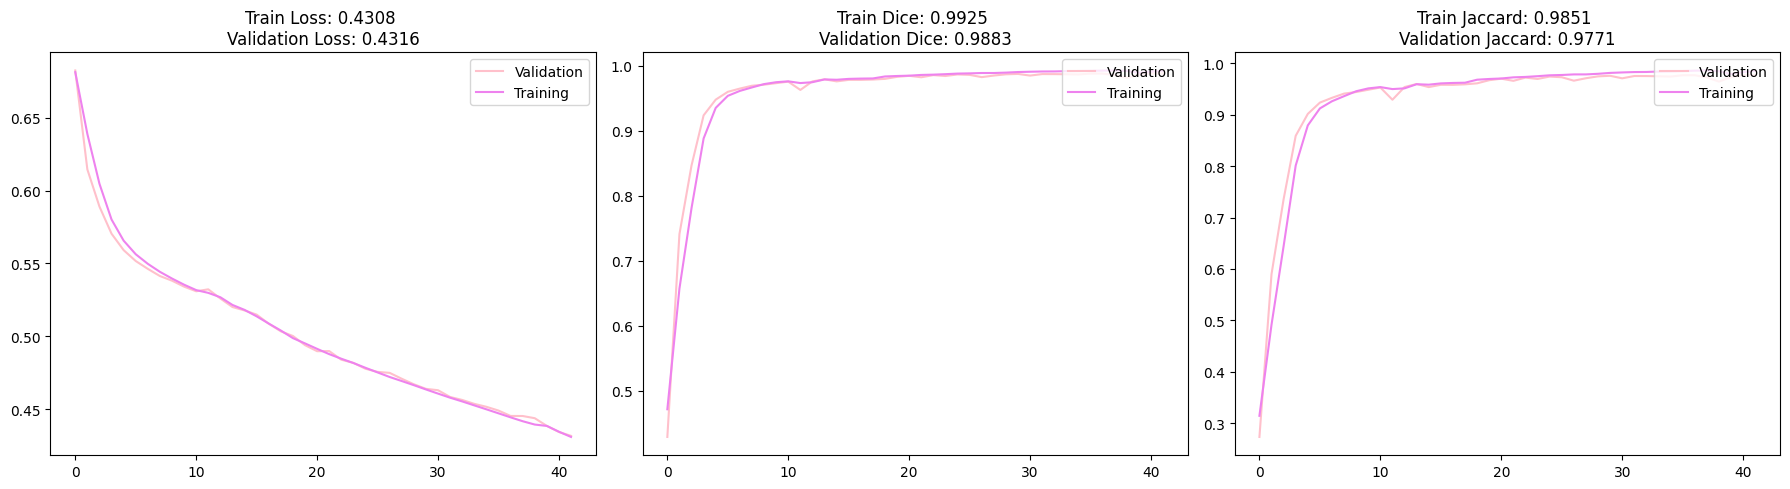

train epoch 43/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4277 | Dice: 0.9931 | IoU: 0.9864


val epoch 43/50: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.4296 | Dice: 0.9880 | IoU: 0.9765


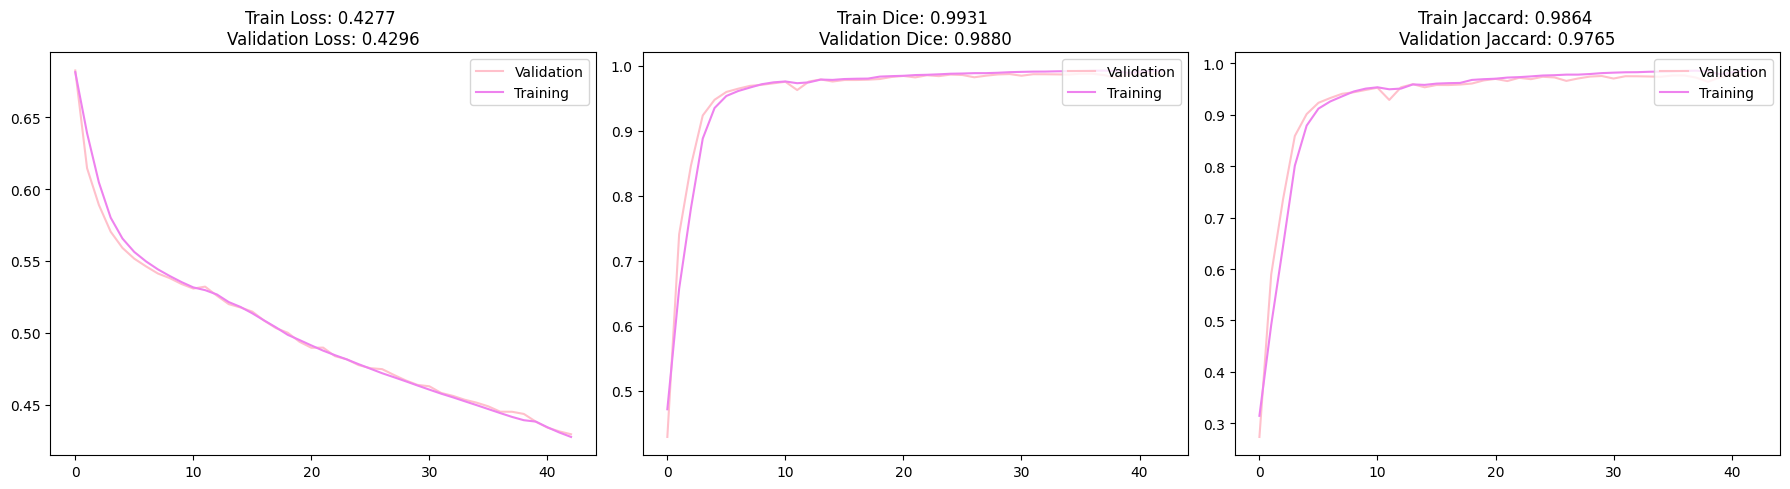

train epoch 44/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4248 | Dice: 0.9933 | IoU: 0.9867


val epoch 44/50: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Loss: 0.4272 | Dice: 0.9881 | IoU: 0.9767


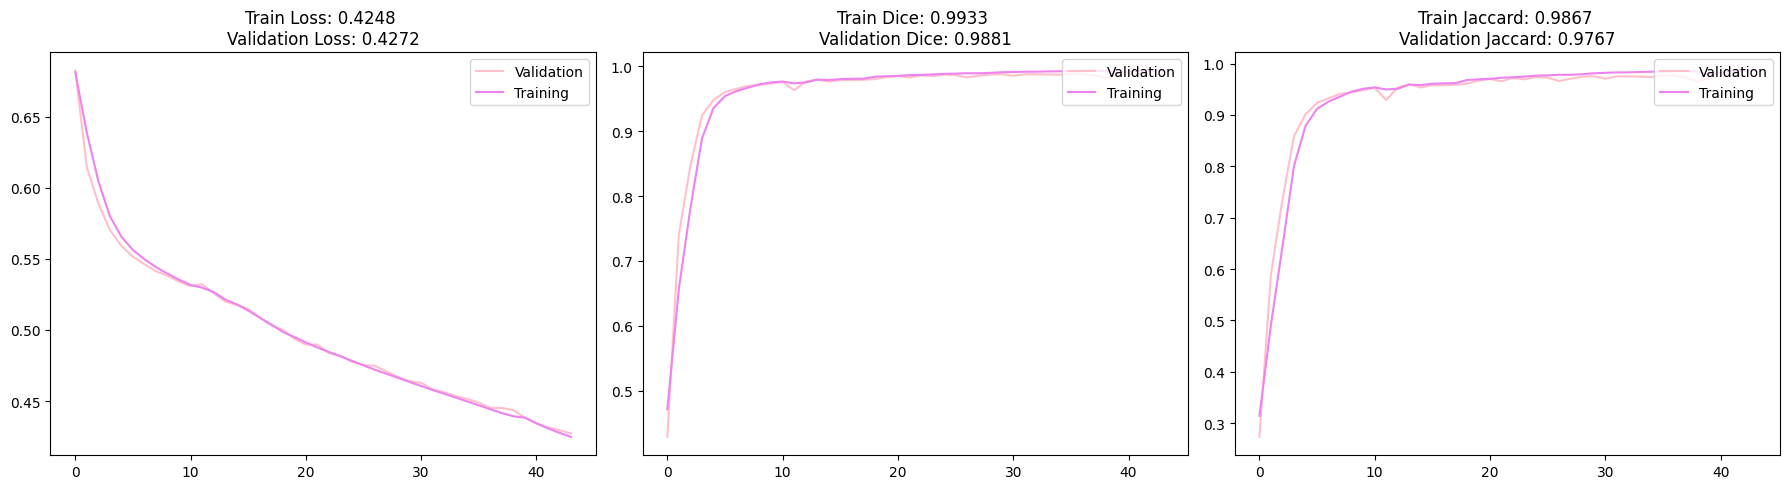

train epoch 45/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4220 | Dice: 0.9935 | IoU: 0.9872


val epoch 45/50: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Loss: 0.4235 | Dice: 0.9884 | IoU: 0.9772


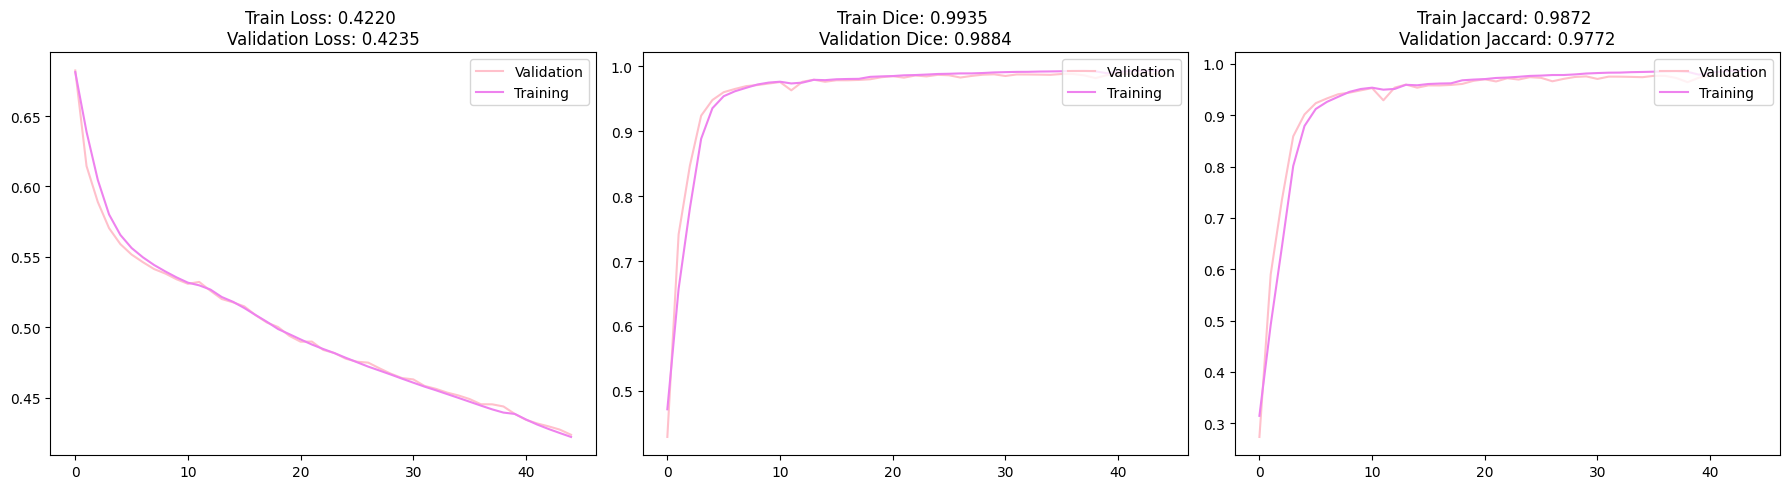

train epoch 46/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4191 | Dice: 0.9939 | IoU: 0.9878


val epoch 46/50: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Loss: 0.4217 | Dice: 0.9880 | IoU: 0.9763


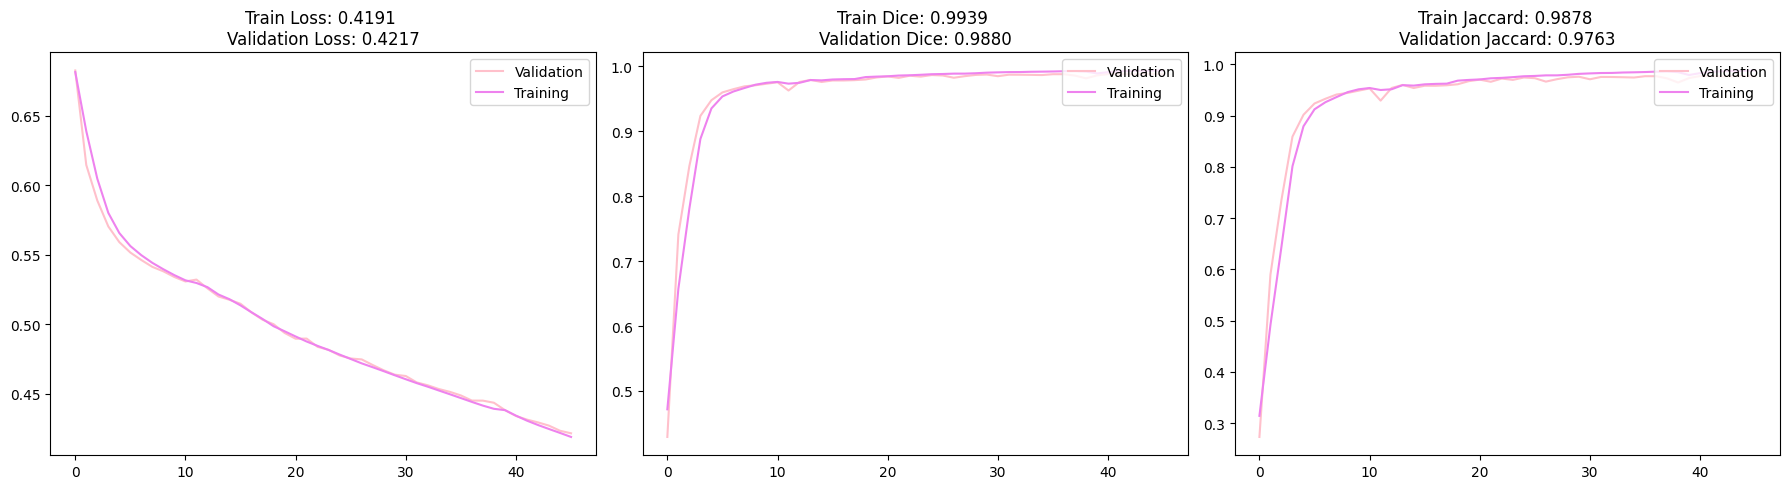

train epoch 47/50: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


Loss: 0.4164 | Dice: 0.9939 | IoU: 0.9878


val epoch 47/50: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.4193 | Dice: 0.9878 | IoU: 0.9761


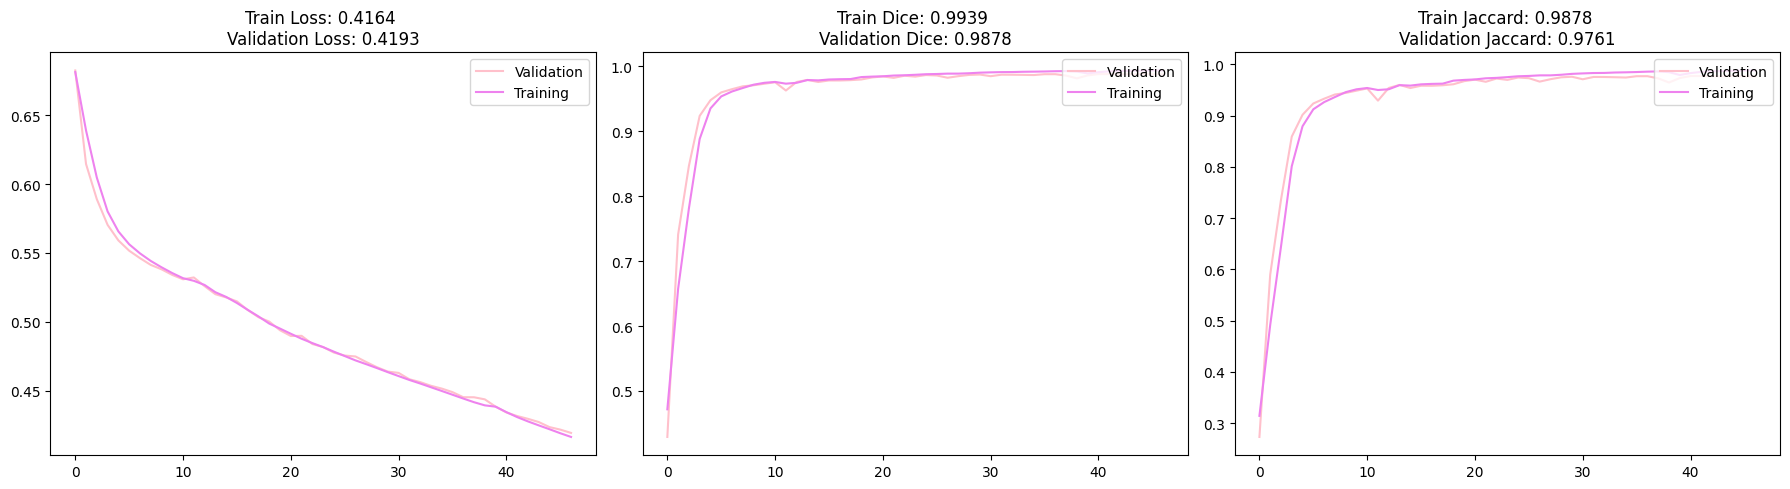

train epoch 48/50: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


Loss: 0.4133 | Dice: 0.9943 | IoU: 0.9886


val epoch 48/50: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Loss: 0.4162 | Dice: 0.9876 | IoU: 0.9757


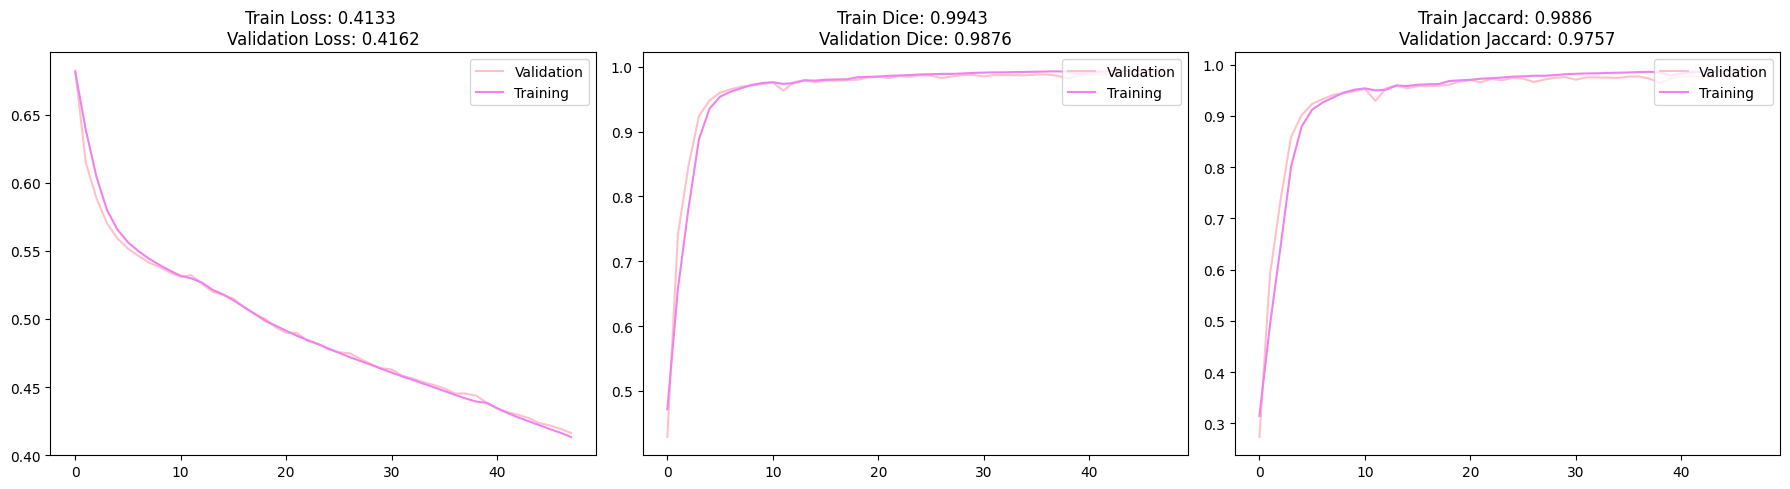

train epoch 49/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4106 | Dice: 0.9940 | IoU: 0.9882


val epoch 49/50: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Loss: 0.4127 | Dice: 0.9887 | IoU: 0.9779


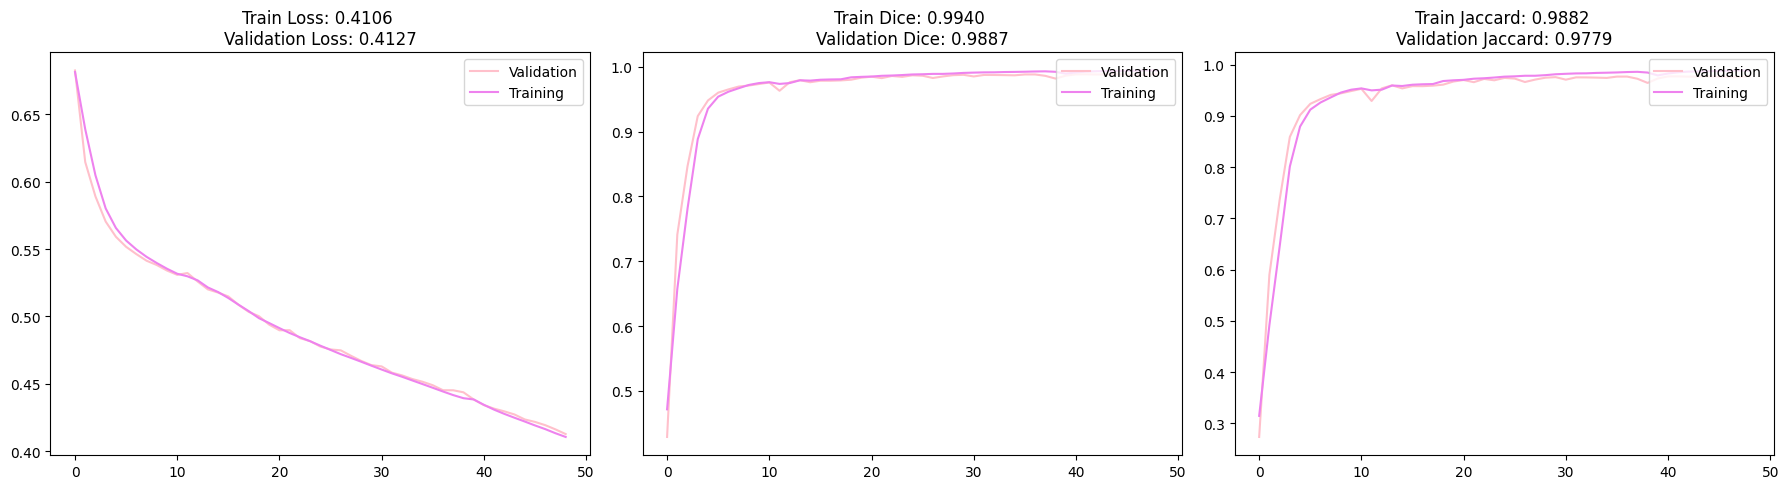

train epoch 50/50: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Loss: 0.4080 | Dice: 0.9941 | IoU: 0.9884


val epoch 50/50: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Loss: 0.4111 | Dice: 0.9878 | IoU: 0.9759


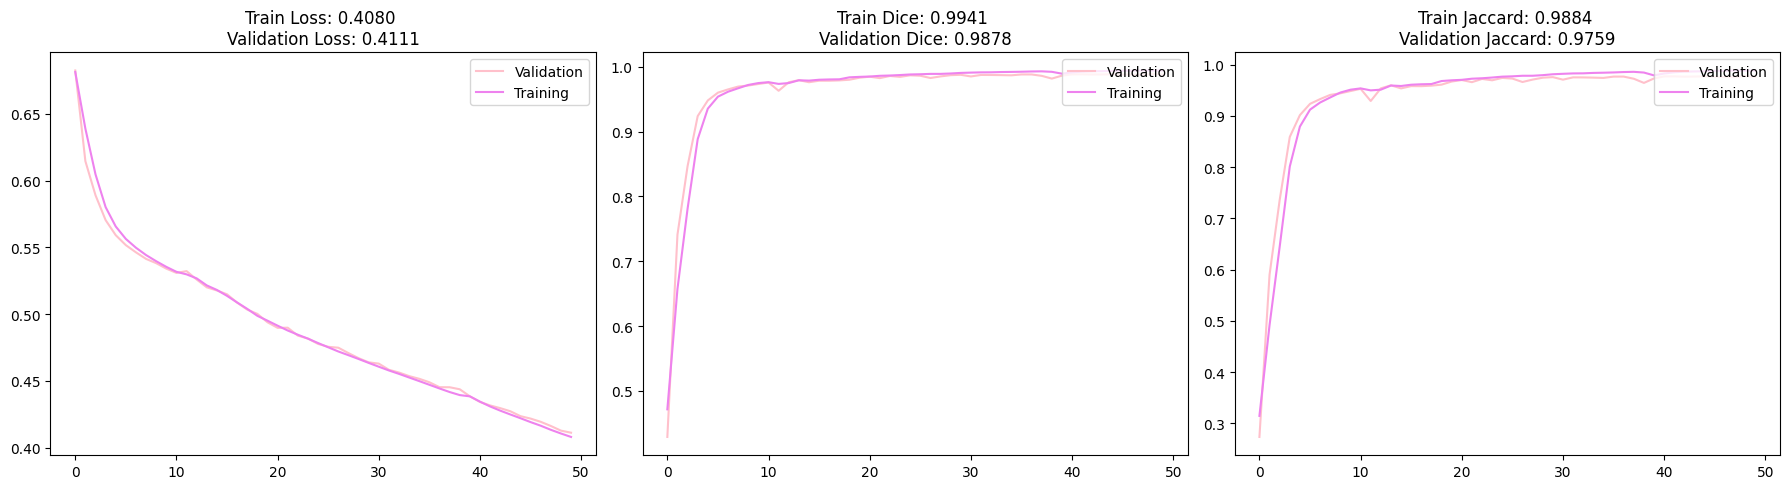


CPU times: user 24min 48s, sys: 1min 11s, total: 26min
Wall time: 40min 37s


In [15]:
%%time
trainer.run()

In [16]:
def coef_metric_per_classes(probabilities, truth, threshold=0.5, eps=1e-9, classes=['WT', 'TC', 'ET', 'BG'], metric='dice'):
    scores = {key: [] for key in classes}
    predictions = (probabilities >= threshold).astype(np.float32)

    for i in range(probabilities.shape[0]):
        for class_, class_name in enumerate(classes):
            prediction = predictions[i, class_]
            truth_ = truth[i, class_]

            if metric == 'dice':
                intersection = 2.0 * np.sum(truth_ * prediction)
                union = np.sum(truth_) + np.sum(prediction)
            elif metric == 'jaccard':
                intersection = np.sum(prediction * truth_)
                union = np.sum(prediction) + np.sum(truth_) - intersection + eps
            else:
                raise ValueError("Unsupported metric. Use 'dice' or 'jaccard'.")

            if np.sum(truth_) == 0 and np.sum(prediction) == 0:
                scores[class_name].append(1.0)
            else:
                scores[class_name].append((intersection + eps) / (union + eps))

    return scores

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = coef_metric_per_classes(logits, targets, metric='dice')
            iou_scores = coef_metric_per_classes(logits, targets, metric='jaccard')

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [17]:
model.eval();

In [18]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, valid_dl, ['WT', 'TC', 'ET', 'BG'])

CPU times: user 2.11 s, sys: 50.5 ms, total: 2.16 s
Wall time: 3.2 s


In [19]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

WT dice    WT jaccard   TC dice  TC jaccard  ET dice  ET jaccard  \
13  2.272727e-12  2.272727e-12  0.822327    0.698264      1.0         1.0   
0   1.428571e-10  1.428571e-10  0.915345    0.843904      1.0         1.0   
30  1.000000e+00  1.000000e+00  0.825749    0.703214      1.0         1.0   
29  1.000000e+00  1.000000e+00  0.867004    0.765232      1.0         1.0   
51  1.052632e-11  1.052632e-11  0.795632    0.660623      1.0         1.0   

     BG dice  BG jaccard  
13  0.989922    0.980045  
0   0.987127    0.974580  
30  0.991930    0.983989  
29  0.986672    0.973694  
51  0.983937    0.968382

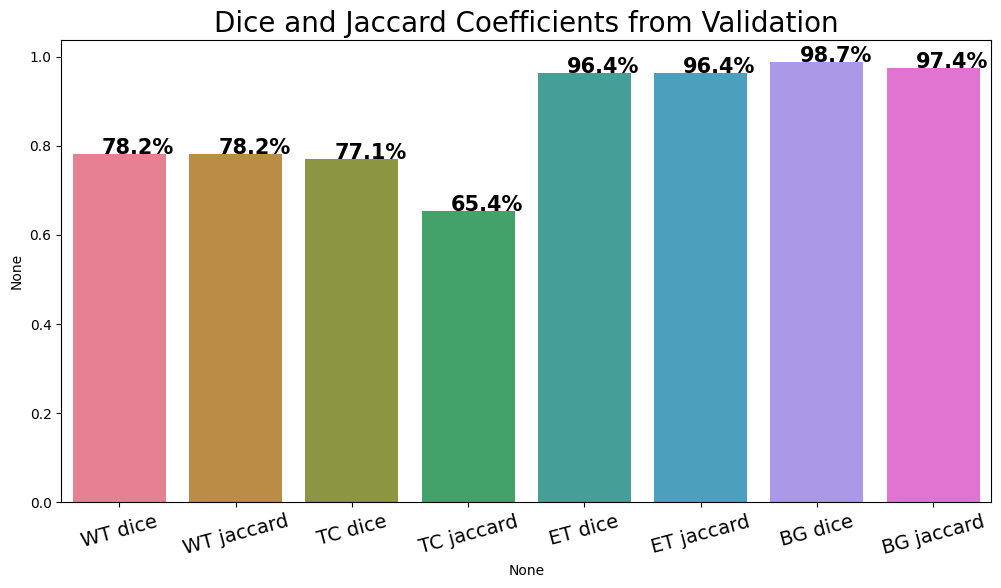

In [20]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = val_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), hue=val_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(val_metics_df.mean().index)))
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')

plt.show()

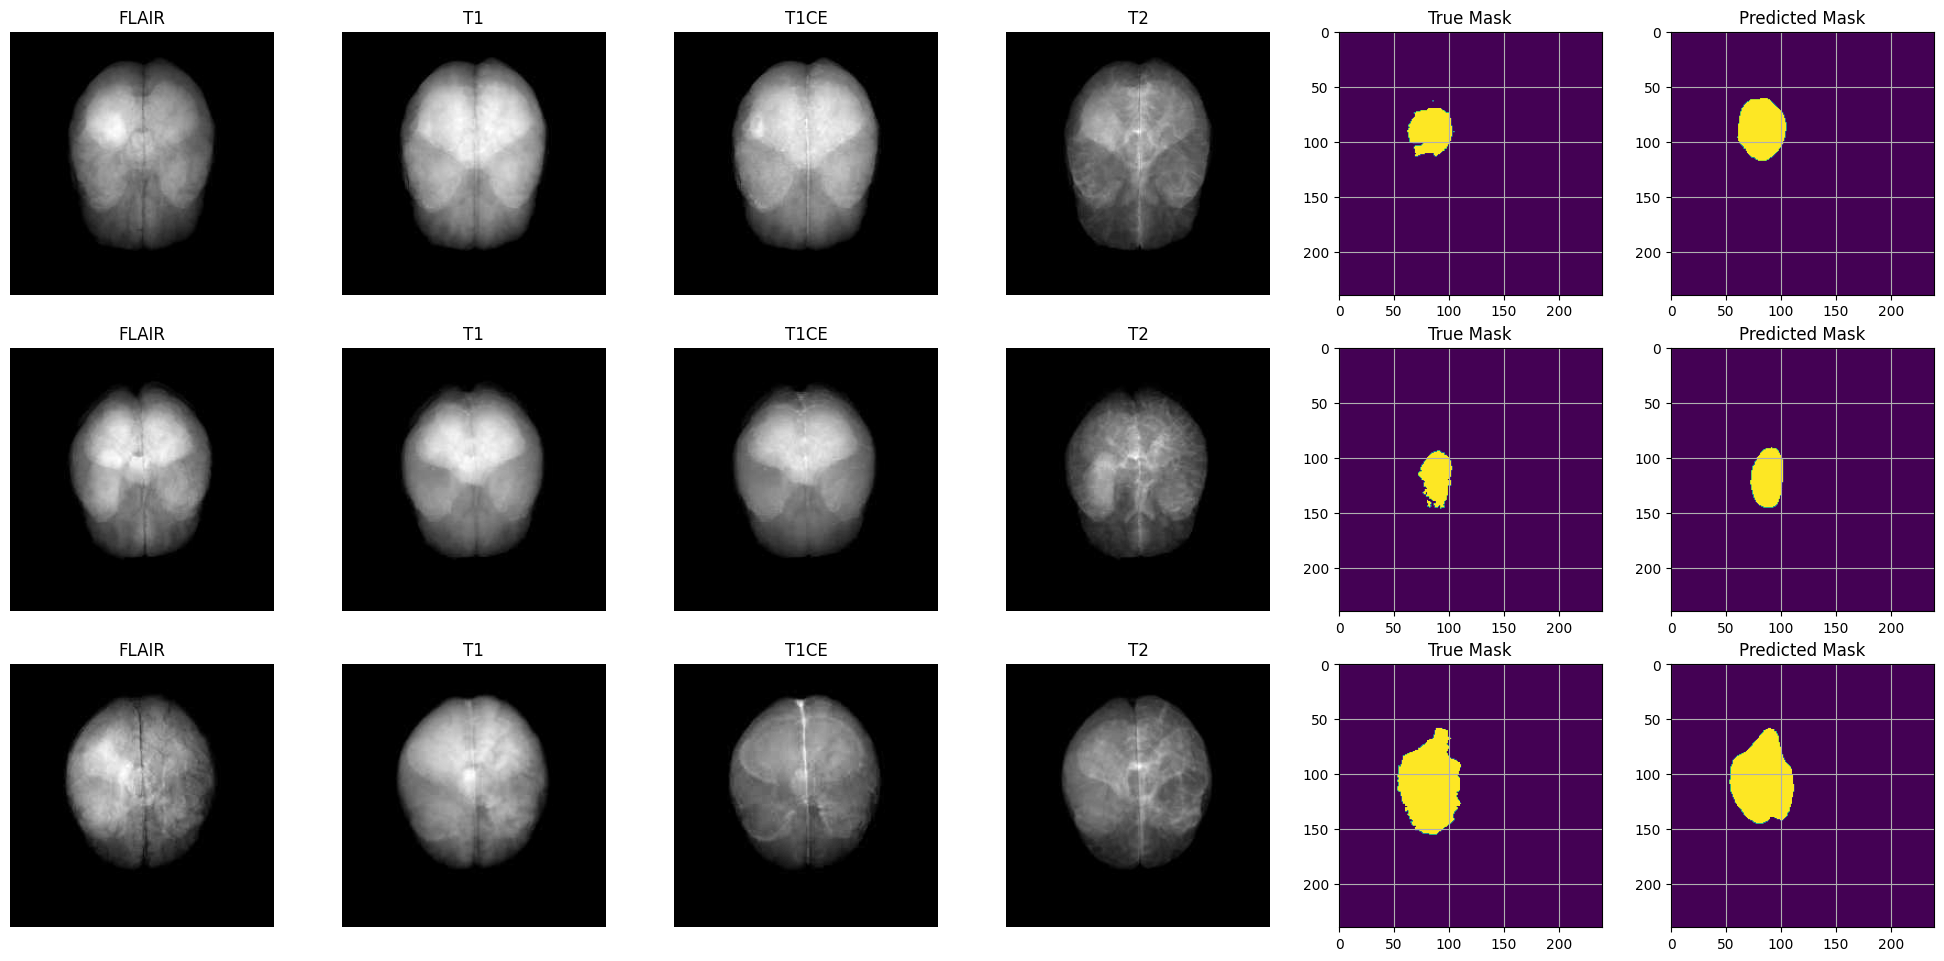

In [28]:
def show_results(model, test_dl):
    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images.float())

    preds = torch.argmax(outputs, dim=1)
    masks = torch.argmax(masks, dim=1)
    #masks = masks * 84
    #preds = preds * 84

    plt.figure(figsize=(25, 65))

    for i in range(3):
        for j in range(len(modality_types)):
            plt.subplot(16, 6, 6 * i + j + 1)
            plt.axis('off')
            plt.title(modality_types[j])
            plt.imshow(images[i][j].cpu(), cmap='gray')

        # show True Mask
        plt.subplot(16, 6, 6 * i + 5)
        plt.title('True Mask')
        plt.grid()
        plt.imshow(255 - masks[i].cpu(), cmap='viridis')

        # show Predicted Mask
        plt.subplot(16, 6, 6 * i + 6)
        plt.title('Predicted Mask')
        plt.grid()
        plt.imshow(255 - preds[i].cpu(), cmap='viridis')

    plt.show()

show_results(model, valid_dl)

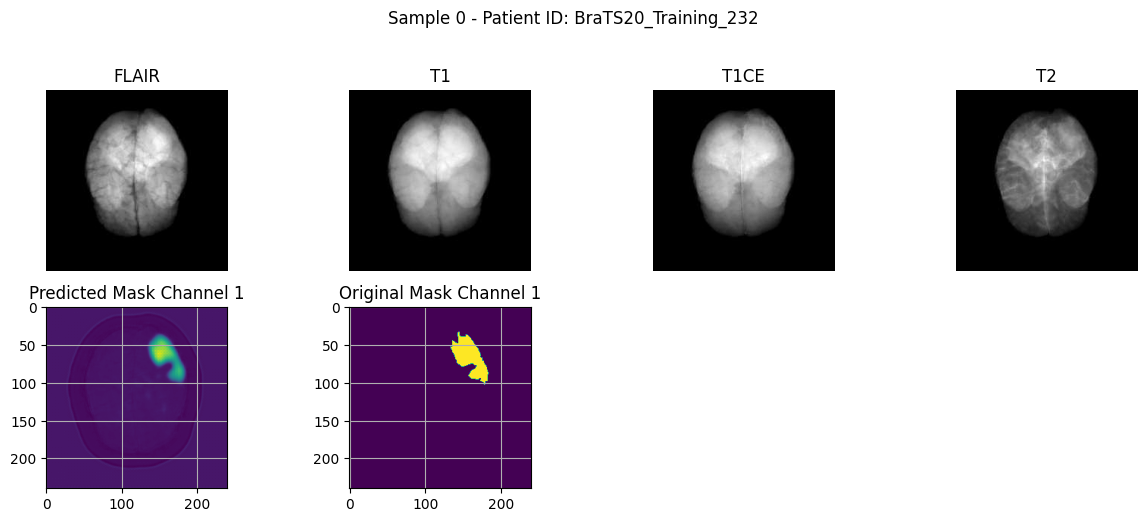

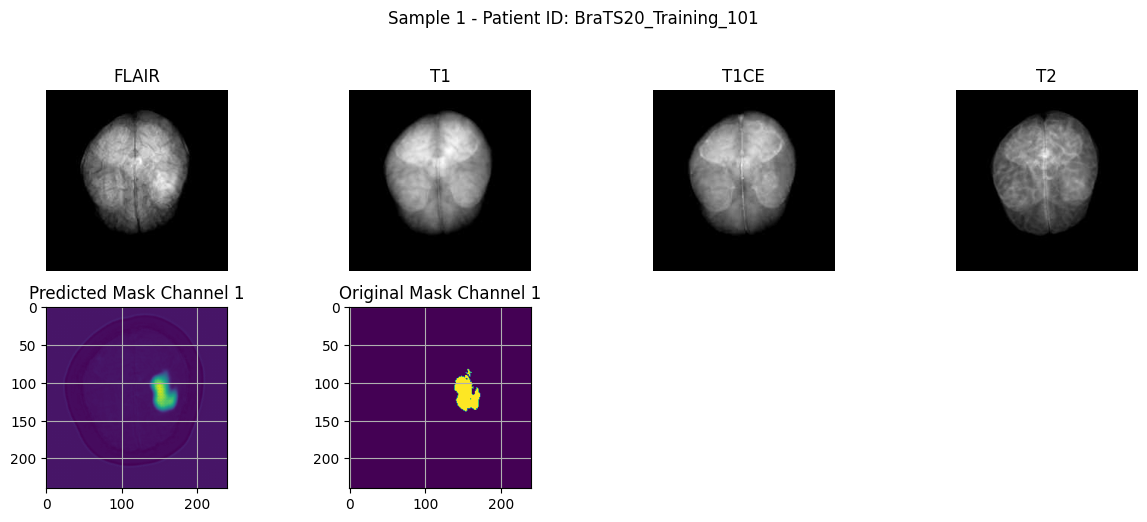

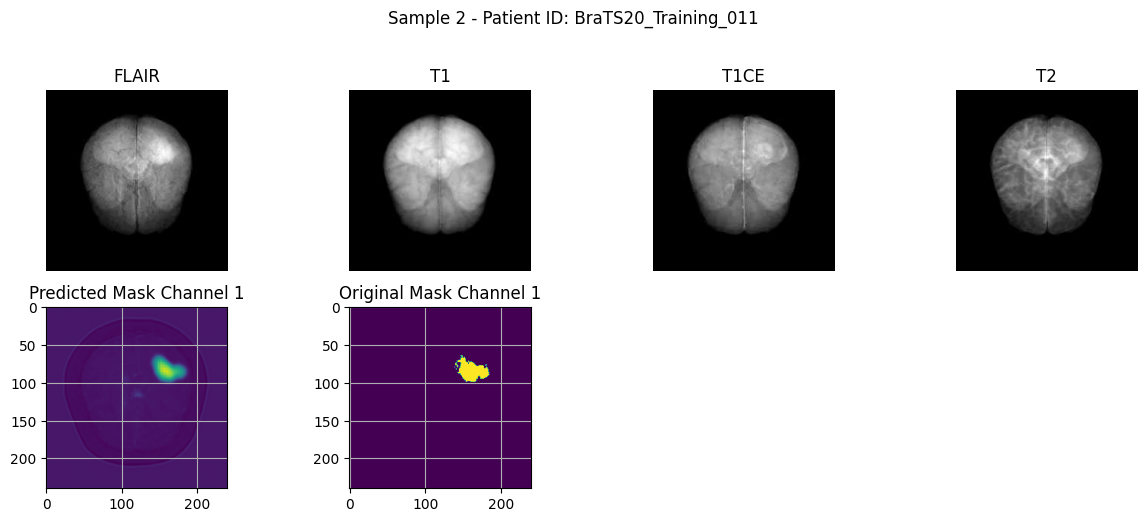

In [22]:
def visualize_predictions(dataset, model, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with three rows
        plt.figure(figsize=(15, 8))

        # Visualize the MRI modalities in the first row
        for j in range(len(modality_types)):
            plt.subplot(3, len(modality_types), j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Forward pass to get predictions
        with torch.no_grad():
            model_input = torch.tensor(image).unsqueeze(0).to(device).float()
            prediction = model(model_input).squeeze().cpu().numpy()

        # Visualize channels 1 and 3 of the predicted segmentation mask in the second row
        plt.subplot(3, len(modality_types), len(modality_types) + 1)
        plt.imshow(prediction[1], cmap='viridis')
        plt.grid()
        plt.title("Predicted Mask Channel 1")

        plt.subplot(3, len(modality_types), len(modality_types) + 2)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("Original Mask Channel 1")

        plt.suptitle(f"Sample {i} - Patient ID: {patient_id}")
        plt.show()

visualize_predictions(train_ds, model, modality_types, num_samples=3)